# Project 5: Generative AI Applications (P5)

Author: Christopher Aaron O'Hara

Dataset target: LANL authentication event stream (public CSR datasets)
- https://csr.lanl.gov/data/2017/

Task: Transformer-based event sequence generation with RCA-oriented narrative interpretation.

Project repository: https://github.com/Ohara124c41/generative-modeling-lanl-rca

## Motivation

This project uses LANL-derived network event sequences to study whether a compact Transformer language model can generate plausible telemetry narratives for RCA-style reasoning under a constrained compute budget. The loaded cache contains 300,000 network-flow rows from day 2, with protocol imbalance (PR_17 dominant in the full EDA) and heavy-tailed volume features, so the core challenge is balancing realism, diversity, and stability rather than chasing a single loss number.

The workflow intentionally links generation quality to operational interpretation: after training, generated sequences are scored, mapped to RCA hypotheses, checked with lightweight governance diagnostics (NIST CSF mapping and AIF360 screening), and exported as traceable artifacts for downstream integration work.

In [95]:
# Colab/Server GPU check (T4 expected)
import os
import subprocess
import torch

print("Python executable:", os.sys.executable)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  Total VRAM (GB): {props.total_memory / (1024**3):.2f}")
        print(f"  Compute capability: {props.major}.{props.minor}")
else:
    print("No CUDA GPU visible to this kernel.")

print("\n=== nvidia-smi ===")
try:
    out = subprocess.check_output(["nvidia-smi"], stderr=subprocess.STDOUT, text=True)
    print(out[:2000])  # truncate for notebook readability
except Exception as e:
    print("nvidia-smi not available or failed:", e)


Python executable: /usr/bin/python3
Torch version: 2.10.0+cu128
CUDA available: True
CUDA device count: 1
GPU 0: Tesla T4
  Total VRAM (GB): 14.56
  Compute capability: 7.5

=== nvidia-smi ===
Fri Feb 20 06:39:58 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             29W /   7

## 1) Setup and Dependency Bootstrap

The runtime environment can change across local notebooks and Colab sessions, so dependencies are validated at execution time. Core scientific and deep-learning packages are treated as required for reproducibility, while AIF360 is installed as optional because fairness screening is diagnostic and should not block model execution when add-on backends are unavailable.

In [131]:
import importlib.util
import subprocess
import sys

REQUIRED_PACKAGES = {
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'torch': 'torch',
    'networkx': 'networkx',
    'tqdm': 'tqdm',
}

# Optional package: notebook can continue if installation/import fails.
OPTIONAL_PACKAGES = {
    'aif360': 'aif360==0.6.1',
}


def _missing_imports(required):
    missing = []
    for import_name, pip_name in required.items():
        if importlib.util.find_spec(import_name) is None:
            missing.append(pip_name)
    return missing


def _pip_install(pkgs):
    if not pkgs:
        return []
    cmd = [sys.executable, '-m', 'pip', 'install', '--quiet'] + pkgs
    subprocess.check_call(cmd)
    return pkgs


bootstrap_status = {
    'required_missing_before': [],
    'required_installed_now': [],
    'optional_missing_before': [],
    'optional_installed_now': [],
    'optional_install_failed': [],
}

# Required installs (fail-fast)
required_missing = _missing_imports(REQUIRED_PACKAGES)
bootstrap_status['required_missing_before'] = required_missing.copy()
if required_missing:
    bootstrap_status['required_installed_now'] = _pip_install(required_missing)

# Optional installs (best-effort)
optional_missing = _missing_imports(OPTIONAL_PACKAGES)
bootstrap_status['optional_missing_before'] = optional_missing.copy()
for pkg in optional_missing:
    try:
        _pip_install([pkg])
        bootstrap_status['optional_installed_now'].append(pkg)
    except Exception as e:
        bootstrap_status['optional_install_failed'].append({'package': pkg, 'error': str(e)})

print('Bootstrap status:', bootstrap_status)
if bootstrap_status['optional_install_failed']:
    print('Optional package install failed; notebook will continue and corresponding sections will skip gracefully.')


Bootstrap status: {'required_missing_before': [], 'required_installed_now': [], 'optional_missing_before': ['aif360==0.6.1'], 'optional_installed_now': ['aif360==0.6.1'], 'optional_install_failed': []}


## 2) Imports and Reproducibility Controls

The pipeline depends on deterministic preprocessing and repeatable model runs, so random seeds are fixed across Python, NumPy, and PyTorch. Device detection is logged up front because training duration and feasible ablations are strongly tied to whether CUDA is available.

In [97]:
from pathlib import Path
import os
import re
import gzip
import json
import math
import random
import hashlib
from datetime import datetime, timezone
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print({'seed': SEED, 'device': DEVICE})

# GPU-oriented math setting (safe no-op on CPU or older torch)
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass


{'seed': 42, 'device': 'cuda'}


## 3) Configuration

Configuration centralizes data paths, sampling controls, modeling hyperparameters, generation settings, and persistence targets. Current settings prioritize finishing full experimental comparisons within budget: a 50,000-row modeling cap from the 300,000-row cache, 10 baseline epochs, short ablations, and an extended follow-up on the best short-run configuration (`low_lr_1e4`).

In [98]:
# Paths and run configuration
DATASET_MODE = 'lanl2017_network'

DATA_DIR_OVERRIDE = os.environ.get('P5_DATA_DIR', '').strip()  # optional override
AUTO_MOUNT_COLAB_DRIVE = True
EXTRA_RAW_SEARCH_DIRS = []

if AUTO_MOUNT_COLAB_DRIVE:
    try:
        import google.colab  # type: ignore
        from google.colab import drive  # type: ignore
        drive.mount('/content/drive', force_remount=False)
    except Exception:
        pass

candidate_roots = []
if DATA_DIR_OVERRIDE:
    candidate_roots.append(Path(DATA_DIR_OVERRIDE))
candidate_roots.extend([
    Path('data'),
    Path('/content/drive/MyDrive/data'),
    Path('/content/drive/data'),
    Path('/content/drive/MyDrive/data processed 2017'),
    Path('/content/drive/data processed 2017'),
])

selected_root = None
for cand in candidate_roots:
    try:
        if cand.exists():
            selected_root = cand
            break
    except Exception:
        continue

if selected_root is None:
    selected_root = Path('data')

# Detect whether selected root is a standalone processed folder
standalone_cache_name = f'p5_{DATASET_MODE}_events_subset.csv.gz'
is_standalone_processed = (selected_root / standalone_cache_name).exists()

if is_standalone_processed:
    DATA_DIR = selected_root.parent
    PROCESSED_BASE_DIR = selected_root
    PROCESSED_DIR = selected_root
    RAW_DIR = DATA_DIR / 'raw'
else:
    # Normalize if user points into processed folders
    if selected_root.name == 'processed':
        DATA_DIR = selected_root.parent
    elif selected_root.name == '2017' and selected_root.parent.name == 'processed':
        DATA_DIR = selected_root.parent.parent
    else:
        DATA_DIR = selected_root

    RAW_DIR = DATA_DIR / 'raw'
    PROCESSED_BASE_DIR = DATA_DIR / 'processed'
    PROCESSED_SUBDIR = os.environ.get('P5_PROCESSED_SUBDIR', '').strip()
    if not PROCESSED_SUBDIR and (PROCESSED_BASE_DIR / '2017').exists():
        PROCESSED_SUBDIR = '2017'
    PROCESSED_DIR = (PROCESSED_BASE_DIR / PROCESSED_SUBDIR) if PROCESSED_SUBDIR else PROCESSED_BASE_DIR

MODEL_DIR = PROCESSED_DIR / 'models'
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_BASE_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Optional explicit raw file list (kept for compatibility; typically unused now)
_env_raw_list = os.environ.get('P5_RAW_FILE_LIST', '').strip()
RAW_FILE_LIST = [x.strip() for x in _env_raw_list.split(';') if x.strip()]
RAW_FILE_OVERRIDE = ''
AUTO_SELECT_2017_NETFLOW = True
AUTO_SELECT_2017_MAX_DAYS = 2

# Optional WLS context controls
WLS_CONTEXT_FILE_LIST = []
AUTO_SELECT_WLS_CONTEXT = True
AUTO_SELECT_WLS_MAX_FILES = 2
MAX_WLS_CONTEXT_LINES = 50000

NETWORK2017_PATH = RAW_DIR / '2017' / 'netflow_day-03.csv'

# Cache controls
USE_PROCESSED_CACHE_IF_AVAILABLE = True
WRITE_PROCESSED_CACHE = True
ENFORCE_RAW_MB_PER_SOURCE = True
MAX_RAW_MB_PER_SOURCE = 50

# Parsing/sample controls
MAX_EVENTS = 50000
MIN_TOK_FREQ = 3
MAX_VOCAB = 20000
SEQ_LEN = 18
STRIDE = 6

# EDA controls
EDA_ENABLE_PLOTS = True
EDA_SAMPLE_MAX = 30000

# Tokenization/feature controls
TIME_BIN_SECONDS = 300
COMP_BUCKETS = 2048
PORT_BUCKETS = 2048
STATUS_BUCKETS = 16
TRAIN_FRACTION = 0.90

# Model controls
BATCH_SIZE = 256
EPOCHS = 10
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
LABEL_SMOOTHING = 0.0

# Aliases expected by later cells
D_MODEL = EMBED_DIM
N_HEADS = 4
N_LAYERS = NUM_LAYERS
BLOCK_SIZE = 64
GEN_MAX_NEW_TOKENS = 96
GEN_TEMPERATURE = 1.05
GEN_TOP_K = 50
NUM_GENERATIONS = 8
REPETITION_PENALTY = 1.15
NO_REPEAT_LAST_N = 40

# Training comparison controls
RUN_ABLATIONS = True
ABLATION_EPOCHS = 2
SAVE_MODEL_CHECKPOINTS = True
SAVE_ALL_ABLATION_CHECKPOINTS = False

# Dataloader controls
DATALOADER_NUM_WORKERS = 2
DATALOADER_PIN_MEMORY = (DEVICE == 'cuda')
DATALOADER_PERSISTENT_WORKERS = bool(DATALOADER_NUM_WORKERS > 0)

# Runtime budget controls (used by training cell)
MAX_TRAIN_MINUTES = 120
TRAINING_BUDGET_MINUTES = MAX_TRAIN_MINUTES

# Output paths
PROCESSED_EVENTS_PATH = PROCESSED_DIR / f'p5_{DATASET_MODE}_events_subset.csv.gz'
PROCESSED_EVENTS_META_PATH = PROCESSED_DIR / f'p5_{DATASET_MODE}_events_subset_meta.json'
PROCESSED_WLS_PATH = PROCESSED_DIR / 'p5_wls_context_subset.csv.gz'
TOKENIZER_PATH = PROCESSED_DIR / f'p5_{DATASET_MODE}_tokenizer.pkl'
MODEL_BASELINE_PATH = MODEL_DIR / 'baseline_lm.pt'
MODEL_ABLATION_PATH = MODEL_DIR / 'ablation_lm.pt'
METRICS_PATH = PROCESSED_DIR / 'metrics_summary.csv'
GENERATIONS_PATH = PROCESSED_DIR / 'generated_samples.csv'
RCA_PATH = PROCESSED_DIR / 'rca_hypotheses.csv'

print({'DATA_DIR': str(DATA_DIR), 'PROCESSED_DIR': str(PROCESSED_DIR), 'MODEL_DIR': str(MODEL_DIR)})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'DATA_DIR': 'data', 'PROCESSED_DIR': 'data/processed', 'MODEL_DIR': 'data/processed/models'}


## 4) Data Ingestion and Inspection

Ingestion verifies that event records can be loaded consistently and that key telemetry fields are present before any model fitting. The workflow prefers processed-cache loading for repeatability and speed, but still preserves raw-file parsing logic so the same notebook can regenerate caches from source files when needed.

### File Integrity Probe

The probe is kept to detect delimiter or encoding problems when raw files are used. In this run the notebook relies on a processed cache, so probe file lists are empty by design; that is acceptable because structural validation is performed on the loaded cache immediately afterward.

In [100]:
PROBE_NETFLOW_LINES = 2000
PROBE_RANDOM_LINES = 8
PROBE_WLS_LINES = 2000


def _probe_select_netflow_files():
    if RAW_FILE_LIST:
        return [Path(x) for x in RAW_FILE_LIST if Path(x).exists()]
    p2017 = RAW_DIR / '2017'
    if p2017.exists():
        return sorted(p2017.glob('netflow_day-*.csv'))[:AUTO_SELECT_2017_MAX_DAYS]
    return []


def _probe_select_wls_files():
    if WLS_CONTEXT_FILE_LIST:
        return [Path(x) for x in WLS_CONTEXT_FILE_LIST if Path(x).exists()]
    p2017 = RAW_DIR / '2017'
    if p2017.exists():
        return sorted(p2017.glob('wls_day-*.json'))[:AUTO_SELECT_WLS_MAX_FILES]
    return []


def _reservoir_sample_lines(path: Path, k: int = 8, max_lines: int = 2000):
    sample = []
    seen = 0
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.rstrip('\n')
            if not line:
                continue
            seen += 1
            if len(sample) < k:
                sample.append(line)
            else:
                j = random.randint(1, seen)
                if j <= k:
                    sample[j - 1] = line
            if seen >= max_lines:
                break
    return sample, seen


probe_netflow_files = _probe_select_netflow_files()
probe_wls_files = _probe_select_wls_files()

print({'probe_netflow_files': [str(p) for p in probe_netflow_files], 'probe_wls_files': [str(p) for p in probe_wls_files]})

netflow_probe_rows = []
for fp in probe_netflow_files:
    file_mb = fp.stat().st_size / (1024 * 1024)
    chunk_ok = False
    chunk_rows = 0
    chunk_cols = None
    chunk_err = None

    try:
        chunk = pd.read_csv(fp, nrows=PROBE_NETFLOW_LINES, header=None, on_bad_lines='skip')
        chunk_ok = True
        chunk_rows = int(len(chunk))
        chunk_cols = int(chunk.shape[1])
    except Exception as e:
        chunk_err = str(e)

    sampled, seen = _reservoir_sample_lines(fp, k=PROBE_RANDOM_LINES, max_lines=PROBE_NETFLOW_LINES)
    field_counts = [len(x.split(',')) for x in sampled]

    netflow_probe_rows.append({
        'file': fp.name,
        'size_mb': round(file_mb, 2),
        'chunk_ok': chunk_ok,
        'chunk_rows': chunk_rows,
        'chunk_cols': chunk_cols,
        'sample_lines_seen': seen,
        'sample_min_fields': int(min(field_counts)) if field_counts else None,
        'sample_max_fields': int(max(field_counts)) if field_counts else None,
        'chunk_error': chunk_err,
    })

netflow_probe_df = pd.DataFrame(netflow_probe_rows)
if len(netflow_probe_df) > 0:
    display(netflow_probe_df)

wls_probe_rows = []
for fp in probe_wls_files:
    file_mb = fp.stat().st_size / (1024 * 1024)
    valid = 0
    invalid = 0
    seen = 0

    with open(fp, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.rstrip('\n')
            if not line:
                continue
            seen += 1
            try:
                obj = json.loads(line)
                if isinstance(obj, dict):
                    valid += 1
                else:
                    invalid += 1
            except Exception:
                invalid += 1
            if seen >= PROBE_WLS_LINES:
                break

    wls_probe_rows.append({
        'file': fp.name,
        'size_mb': round(file_mb, 2),
        'lines_checked': seen,
        'json_valid': valid,
        'json_invalid': invalid,
        'valid_ratio': (valid / seen) if seen > 0 else None,
    })

wls_probe_df = pd.DataFrame(wls_probe_rows)
if len(wls_probe_df) > 0:
    display(wls_probe_df)

if len(netflow_probe_df) > 0:
    failed_chunks = (~netflow_probe_df['chunk_ok']).sum()
    print({'netflow_files': len(netflow_probe_df), 'netflow_failed_chunks': int(failed_chunks)})
if len(wls_probe_df) > 0:
    low_valid = (wls_probe_df['valid_ratio'] < 0.8).sum()
    print({'wls_files': len(wls_probe_df), 'wls_low_json_valid_ratio': int(low_valid)})


{'probe_netflow_files': [], 'probe_wls_files': []}


### Probe Analysis

The probe output shows no raw files were sampled in this session, which matches the cache-first path used for this run. The decisive data-quality checks therefore come from the ingestion cell: 300,000 events loaded, one source file (`netflow_day-02.csv`), and day tag `[2]`, followed by schema and distribution inspection tables.

In [101]:
def _infer_day_from_name(name: str):
    m = re.search(r'day[-_]?0*(\d+)', str(name).lower())
    if m:
        return int(m.group(1))
    return None


def _find_processed_cache_candidates():
    candidates = []
    direct = [
        PROCESSED_EVENTS_PATH,
        PROCESSED_DIR / f'p5_{DATASET_MODE}_events_subset.csv.gz',
        PROCESSED_BASE_DIR / f'p5_{DATASET_MODE}_events_subset.csv.gz',
        Path('/content/drive/MyDrive/data processed 2017/p5_lanl2017_network_events_subset.csv.gz'),
        Path('/content/drive/data processed 2017/p5_lanl2017_network_events_subset.csv.gz'),
        Path('/content/drive/MyDrive/data/processed/2017/p5_lanl2017_network_events_subset.csv.gz'),
        Path('/content/drive/data/processed/2017/p5_lanl2017_network_events_subset.csv.gz'),
    ]
    for p in direct:
        try:
            if p.exists() and p.is_file():
                candidates.append(p)
        except Exception:
            pass

    if not candidates:
        for root in [PROCESSED_DIR, PROCESSED_BASE_DIR, Path('/content/drive/MyDrive'), Path('/content/drive')]:
            try:
                if root.exists():
                    candidates.extend(list(root.rglob('*events_subset.csv.gz')))
            except Exception:
                pass

    # de-duplicate
    uniq = []
    seen = set()
    for c in candidates:
        k = str(c)
        if k not in seen:
            seen.add(k)
            uniq.append(c)
    return uniq


def _iter_lines(path: Path):
    if path.suffix == '.gz':
        with gzip.open(path, 'rt', encoding='utf-8', errors='ignore') as f:
            for line in f:
                yield line.rstrip('\\n')
    else:
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                yield line.rstrip('\\n')


def _to_int(x):
    try:
        return int(float(str(x).strip()))
    except Exception:
        return None


def _to_float(x):
    try:
        return float(str(x).strip())
    except Exception:
        return None


def parse_lanl2017_network(line: str):
    parts = [p.strip() for p in line.split(',')]
    if len(parts) < 11:
        return None

    t, dur, src_dev, dst_dev, proto, src_port, dst_port, src_pkts, dst_pkts, src_bytes, dst_bytes = parts[:11]
    t_int = _to_int(t)
    if t_int is None:
        return None

    return {
        'time': t_int,
        'src_user': 'UNK',
        'dst_user': 'UNK',
        'src_comp': src_dev,
        'dst_comp': dst_dev,
        'auth_type': f'PROTO_{proto}',
        'logon_type': f'SPORT_{src_port}',
        'orientation': 'NETFLOW',
        'status': 'FLOW',
        'duration': _to_float(dur),
        'protocol': str(proto),
        'src_port': src_port,
        'dst_port': dst_port,
        'src_packets': _to_int(src_pkts),
        'dst_packets': _to_int(dst_pkts),
        'src_bytes': _to_int(src_bytes),
        'dst_bytes': _to_int(dst_bytes),
    }


# 1) Processed cache first
cache_candidates = _find_processed_cache_candidates()
raw_load_mode = 'processed_cache' if (USE_PROCESSED_CACHE_IF_AVAILABLE and len(cache_candidates) > 0) else 'raw_stream'
raw_paths = []

if raw_load_mode == 'processed_cache':
    # prefer canonical path if present, else largest discovered cache
    preferred = [c for c in cache_candidates if c.name == f'p5_{DATASET_MODE}_events_subset.csv.gz']
    if len(preferred) > 0:
        PROCESSED_EVENTS_PATH = preferred[0]
    else:
        cache_candidates = sorted(cache_candidates, key=lambda x: x.stat().st_size if x.exists() else 0, reverse=True)
        PROCESSED_EVENTS_PATH = cache_candidates[0]

    raw_df = pd.read_csv(PROCESSED_EVENTS_PATH)
    print('Loaded processed event subset cache:', PROCESSED_EVENTS_PATH)
else:
    # 2) Optional raw fallback if cache is unavailable
    search_raw = []
    if RAW_FILE_LIST:
        search_raw.extend([Path(x) for x in RAW_FILE_LIST if Path(x).exists()])
    if (RAW_DIR / '2017').exists():
        search_raw.extend(sorted((RAW_DIR / '2017').glob('netflow_day-*.csv'))[:AUTO_SELECT_2017_MAX_DAYS])

    search_raw = [p for p in search_raw if p.exists() and p.is_file()]
    if len(search_raw) == 0:
        raise FileNotFoundError(
            'No processed cache or raw netflow files were found. '
            'Provide p5_lanl2017_network_events_subset.csv.gz under processed folder.'
        )

    raw_paths = search_raw
    print('Using raw files:', [str(p) for p in raw_paths])

    byte_cap = int(MAX_RAW_MB_PER_SOURCE * 1024 * 1024)
    source_bytes = {}
    records = []

    for raw_file in raw_paths:
        day_num = _infer_day_from_name(raw_file.name)
        source_bytes.setdefault(raw_file.name, 0)

        for line in _iter_lines(raw_file):
            if ENFORCE_RAW_MB_PER_SOURCE and source_bytes[raw_file.name] >= byte_cap:
                break
            source_bytes[raw_file.name] += len(line.encode('utf-8', errors='ignore')) + 1

            obj = parse_lanl2017_network(line)
            if obj is not None:
                obj['source_file'] = raw_file.name
                obj['data_day'] = day_num
                records.append(obj)

            if MAX_EVENTS is not None and len(records) >= MAX_EVENTS:
                break

        if MAX_EVENTS is not None and len(records) >= MAX_EVENTS:
            break

    if len(records) < 2000:
        raise ValueError('Too few parsed events. Verify netflow file format or cache path.')

    raw_df = pd.DataFrame(records)
    if WRITE_PROCESSED_CACHE:
        raw_df.to_csv(PROCESSED_EVENTS_PATH, index=False, compression='gzip')

# Ensure expected columns for downstream cells
if 'source_file' not in raw_df.columns:
    raw_df['source_file'] = 'processed_cache'
if 'data_day' not in raw_df.columns:
    raw_df['data_day'] = raw_df['source_file'].astype(str).apply(_infer_day_from_name)

# Optional WLS processed context load
wls_context_df = None
wls_candidates = [
    PROCESSED_WLS_PATH,
    PROCESSED_DIR / 'p5_wls_context_subset.csv.gz',
    PROCESSED_BASE_DIR / 'p5_wls_context_subset.csv.gz',
    Path('/content/drive/MyDrive/data processed 2017/p5_wls_context_subset.csv.gz'),
    Path('/content/drive/data processed 2017/p5_wls_context_subset.csv.gz'),
]
for wc in wls_candidates:
    try:
        if wc.exists() and wc.is_file():
            wls_context_df = pd.read_csv(wc)
            PROCESSED_WLS_PATH = wc
            break
    except Exception:
        pass

print('raw_load_mode:', raw_load_mode)
print('Loaded events:', len(raw_df))
print('Loaded source files:', raw_df['source_file'].nunique())
if 'data_day' in raw_df.columns:
    print('Loaded days:', sorted([d for d in raw_df['data_day'].dropna().unique().tolist()]))

display(raw_df.head(10))
display(raw_df.describe(include='all').head(12))

if wls_context_df is not None:
    print('Loaded WLS context lines:', len(wls_context_df))
    display(wls_context_df.head(10))

Loaded processed event subset cache: /content/drive/MyDrive/data processed 2017/p5_lanl2017_network_events_subset.csv.gz
raw_load_mode: processed_cache
Loaded events: 300000
Loaded source files: 1
Loaded days: [2]


,time,src_user,dst_user,src_comp,dst_comp,auth_type,logon_type,orientation,status,duration,protocol,src_port,dst_port,src_packets,dst_packets,src_bytes,dst_bytes,source_file,data_day
0,118781,UNK,UNK,Comp364445,Comp547245,PROTO_17,SPORT_Port05507,NETFLOW,FLOW,5580.0,17,Port05507,Port46272,0,755065,0,1042329018,netflow_day-02.csv,2
1,118783,UNK,UNK,Comp450942,Comp829338,PROTO_6,SPORT_Port03137,NETFLOW,FLOW,6976.0,6,Port03137,445,1665,1108,300810,250408,netflow_day-02.csv,2
2,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,14178.0,17,5060,5060,1866,0,1477041,0,netflow_day-02.csv,2
3,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,28147.0,17,5060,5060,3326,0,2656305,0,netflow_day-02.csv,2
4,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,48507.0,17,5060,5060,5423,0,4388449,0,netflow_day-02.csv,2
5,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,63173.0,17,5060,5060,7061,0,5745536,0,netflow_day-02.csv,2
6,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,78594.0,17,5060,5060,8638,0,7052947,0,netflow_day-02.csv,2
7,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,90763.0,17,5060,5060,9943,0,8105139,0,netflow_day-02.csv,2
8,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,104427.0,17,5060,5060,11544,0,9398696,0,netflow_day-02.csv,2
9,118785,UNK,UNK,IP564116,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,115677.0,17,5060,5060,13011,0,10586412,0,netflow_day-02.csv,2


,time,src_user,dst_user,src_comp,dst_comp,auth_type,logon_type,orientation,status,duration,protocol,src_port,dst_port,src_packets,dst_packets,src_bytes,dst_bytes,source_file,data_day
count,300000.000000,300000,300000,300000,300000,300000,300000,300000,300000,3.000000e+05,300000.000000,300000,300000,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,300000,300000.0
unique,NaN,1,1,5668,1584,3,18329,1,1,NaN,NaN,18329,4950,NaN,NaN,NaN,NaN,1,NaN
top,NaN,UNK,UNK,Comp107130,Comp141988,PROTO_17,SPORT_5060,NETFLOW,FLOW,NaN,NaN,5060,5060,NaN,NaN,NaN,NaN,netflow_day-02.csv,NaN
freq,NaN,300000,300000,15430,65450,179674,66092,300000,300000,NaN,NaN,66092,66097,NaN,NaN,NaN,NaN,300000,NaN
mean,120432.006750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.379577e+06,11.934980,NaN,NaN,7.867200e+05,7.478724e+05,1.964466e+08,1.627924e+08,NaN,2.0
std,188.906949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.792855e+06,6.364746,NaN,NaN,3.036942e+07,3.601702e+07,5.689635e+09,6.521489e+09,NaN,0.0
min,118781.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,2.0
25%,120433.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.006000e+05,6.000000,NaN,NaN,2.665000e+03,0.000000e+00,4.133640e+05,0.000000e+00,NaN,2.0
50%,120455.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.354320e+05,17.000000,NaN,NaN,2.001800e+04,0.000000e+00,4.962866e+06,0.000000e+00,NaN,2.0
75%,120541.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.908822e+06,17.000000,NaN,NaN,6.688525e+04,4.140000e+02,3.986722e+07,2.580600e+04,NaN,2.0


Loaded WLS context lines: 50000


,timestamp,event_id,computer,channel,provider,user,domain,source,raw_line,source_file
0,86400,4688,Comp883524,NaN,svchost,Comp883524$,Domain001,NaN,"{""UserName"": ""Comp883524$"", ""EventID"": 4688, ""...",wls_day-02.json
1,86400,4688,Comp836249,NaN,Proc028501,User805641,Domain001,NaN,"{""UserName"": ""User805641"", ""EventID"": 4688, ""L...",wls_day-02.json
2,86400,4688,Comp397468,NaN,services,Comp397468$,Domain001,NaN,"{""UserName"": ""Comp397468$"", ""EventID"": 4688, ""...",wls_day-02.json
3,86400,4672,Comp916004,NaN,NaN,Comp916004$,Domain001,NaN,"{""UserName"": ""Comp916004$"", ""EventID"": 4672, ""...",wls_day-02.json
4,86400,4624,Comp916004,Network,Kerberos,Comp916004$,Domain001,Comp916004,"{""UserName"": ""Comp916004$"", ""EventID"": 4624, ""...",wls_day-02.json
5,86400,4688,Comp836249,NaN,csrss,Comp836249$,Domain001,NaN,"{""UserName"": ""Comp836249$"", ""EventID"": 4688, ""...",wls_day-02.json
6,86400,4688,Comp000116,NaN,services,Comp000116$,Domain001,NaN,"{""UserName"": ""Comp000116$"", ""EventID"": 4688, ""...",wls_day-02.json
7,86400,4634,Comp373973,Network,NaN,Comp373973$,Domain001,NaN,"{""UserName"": ""Comp373973$"", ""EventID"": 4634, ""...",wls_day-02.json
8,86400,4688,Comp763951,NaN,Proc461749,Comp763951$,Domain001,NaN,"{""UserName"": ""Comp763951$"", ""EventID"": 4688, ""...",wls_day-02.json
9,86400,4688,EnterpriseAppServer,NaN,Proc126308,local service,nt authority,NaN,"{""UserName"": ""local service"", ""EventID"": 4688,...",wls_day-02.json


### Analysis

The cache load succeeded with 300,000 events and preserved both source provenance and day metadata. Coverage is strong for modeling features: key numeric traffic fields are populated, and WLS context loading added 50,000 rows for optional cross-source grounding. This gives enough scale for stable token modeling while still allowing capped subsets for faster experimental cycles.

## 5) Exploratory Data Analysis (EDA)

EDA quantifies distribution shape and imbalance before sequence modeling. This matters because heavy tails and skewed protocol frequencies can bias both language-model learning and downstream RCA narratives toward repetitive dominant traffic modes if not explicitly monitored.

{'rows': 300000, 'columns': ['time', 'src_user', 'dst_user', 'src_comp', 'dst_comp', 'auth_type', 'logon_type', 'orientation', 'status', 'duration', 'protocol', 'src_port']}


,source_file,rows
0,netflow_day-02.csv,300000


,data_day,rows
0,2,300000


,feature,nan_count,nan_pct
0,duration,0,0.0
1,src_packets,0,0.0
2,dst_packets,0,0.0
3,src_bytes,0,0.0
4,dst_bytes,0,0.0


,count,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis
duration,300000.0,1.379577e+06,1.792855e+06,0.0,100600.0,635432.0,1908822.50,7.655151e+06,3.214329e+12,1.6768,1.9940
src_packets,300000.0,7.867200e+05,3.036942e+07,0.0,2665.0,20018.0,66885.25,2.396174e+09,9.223015e+14,53.6403,3149.5173
dst_packets,300000.0,7.478724e+05,3.601702e+07,0.0,0.0,0.0,414.00,3.201805e+09,1.297226e+15,63.2702,4400.4956
src_bytes,300000.0,1.964466e+08,5.689635e+09,0.0,413364.0,4962866.0,39867216.00,4.193353e+11,3.237195e+19,50.6767,2799.9846
dst_bytes,300000.0,1.627924e+08,6.521489e+09,0.0,0.0,0.0,25806.00,5.434128e+11,4.252982e+19,55.7071,3511.0333


,duration,src_packets,dst_packets,src_bytes,dst_bytes
duration,3.214329e+12,-5.934940e+10,-2.853612e+11,1.131009e+14,-7.847991e+13
src_packets,-5.934940e+10,9.223015e+14,1.015642e+15,1.707465e+17,1.705096e+17
dst_packets,-2.853612e+11,1.015642e+15,1.297226e+15,1.808065e+17,2.200182e+17
src_bytes,1.131009e+14,1.707465e+17,1.808065e+17,3.237195e+19,2.999110e+19
dst_bytes,-7.847991e+13,1.705096e+17,2.200182e+17,2.999110e+19,4.252982e+19


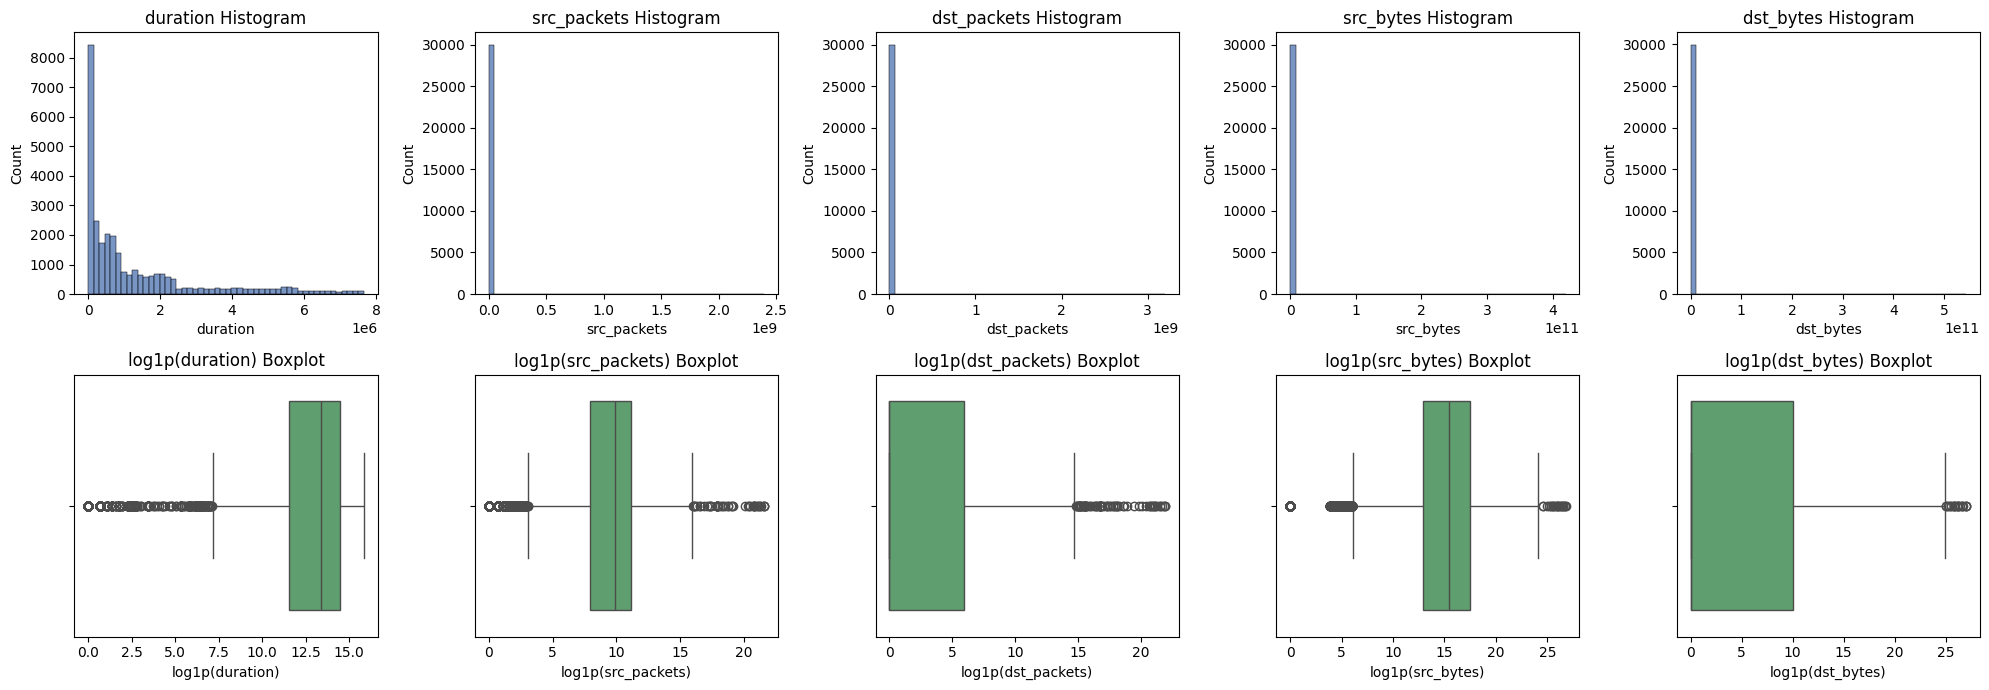

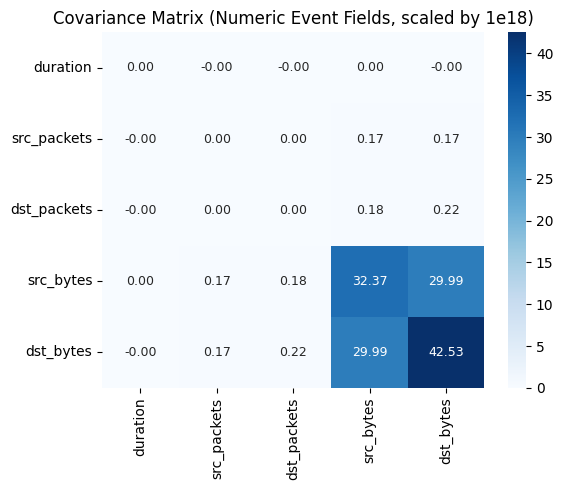

,protocol,count
0,17,179674
1,6,81142
2,1,39184


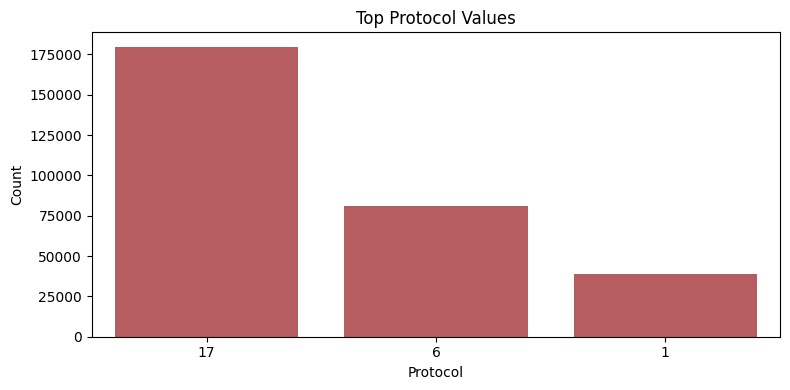

In [106]:
eda_df = raw_df.copy()

print({'rows': len(eda_df), 'columns': list(eda_df.columns)[:12]})

if 'source_file' in eda_df.columns:
    src_counts = eda_df['source_file'].value_counts().reset_index()
    src_counts.columns = ['source_file', 'rows']
    display(src_counts)

if 'data_day' in eda_df.columns:
    day_counts = eda_df['data_day'].value_counts(dropna=False).sort_index().reset_index()
    day_counts.columns = ['data_day', 'rows']
    display(day_counts)

numeric_cols = [c for c in ['duration', 'src_packets', 'dst_packets', 'src_bytes', 'dst_bytes'] if c in eda_df.columns]
if numeric_cols:
    nan_summary = eda_df[numeric_cols].isna().sum().reset_index()
    nan_summary.columns = ['feature', 'nan_count']
    nan_summary['nan_pct'] = 100.0 * nan_summary['nan_count'] / max(len(eda_df), 1)
    nan_summary['nan_pct'] = nan_summary['nan_pct'].round(4)
    display(nan_summary)

    num_stats = eda_df[numeric_cols].describe().T
    num_stats['variance'] = eda_df[numeric_cols].var(numeric_only=True)
    num_stats['skewness'] = eda_df[numeric_cols].skew(numeric_only=True)
    num_stats['kurtosis'] = eda_df[numeric_cols].kurt(numeric_only=True)
    display(num_stats.round(4))

    cov_df = eda_df[numeric_cols].cov()
    display(cov_df.round(4))

    sample_n = min(EDA_SAMPLE_MAX, len(eda_df))
    plot_df = eda_df[numeric_cols].sample(n=sample_n, random_state=SEED) if sample_n < len(eda_df) else eda_df[numeric_cols]

    if EDA_ENABLE_PLOTS:
        fig, axes = plt.subplots(2, max(1, len(numeric_cols)), figsize=(4 * max(1, len(numeric_cols)), 7))
        axes = np.array(axes).reshape(2, -1)

        for j, col in enumerate(numeric_cols):
            sns.histplot(plot_df[col].dropna(), bins=50, ax=axes[0, j], color='#4C72B0')
            axes[0, j].set_title(f'{col} Histogram')
            axes[0, j].set_xlabel(col)
            axes[0, j].set_ylabel('Count')

            sns.boxplot(x=np.log1p(plot_df[col].dropna()), ax=axes[1, j], color='#55A868')
            axes[1, j].set_title(f'log1p({col}) Boxplot')
            axes[1, j].set_xlabel(f'log1p({col})')

        plt.tight_layout()
        plt.show()

        # Scale covariance for readable annotations (fixed decimals, shorter numbers)
        cov_abs_max = float(np.nanmax(np.abs(cov_df.to_numpy()))) if cov_df.size > 0 else 0.0
        if np.isfinite(cov_abs_max) and cov_abs_max > 0:
            cov_exp = int(np.floor(np.log10(cov_abs_max)))
            cov_exp3 = int(np.floor(cov_exp / 3.0) * 3)
            cov_scale = 10.0 ** cov_exp3
        else:
            cov_exp3 = 0
            cov_scale = 1.0

        cov_plot = cov_df / cov_scale

        plt.figure(figsize=(6, 5))
        sns.heatmap(cov_plot, annot=True, fmt='.2f', cmap='Blues', annot_kws={'size': 9})
        if cov_exp3 != 0:
            plt.title(f'Covariance Matrix (Numeric Event Fields, scaled by 1e{cov_exp3})')
        else:
            plt.title('Covariance Matrix (Numeric Event Fields)')
        plt.tight_layout()
        plt.show()

if 'protocol' in eda_df.columns:
    top_proto = eda_df['protocol'].astype(str).value_counts().head(12).reset_index()
    top_proto.columns = ['protocol', 'count']
    display(top_proto)

    if EDA_ENABLE_PLOTS:
        plt.figure(figsize=(8, 4))
        sns.barplot(data=top_proto, x='protocol', y='count', color='#C44E52')
        plt.title('Top Protocol Values')
        plt.xlabel('Protocol')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()


### Analysis

EDA confirms a highly non-Gaussian telemetry profile. Packet/byte features show extreme skew and kurtosis (for example, `src_packets` skew ~53.64 and kurtosis ~3149.52; `dst_packets` skew ~63.27 and kurtosis ~4400.50), while protocol counts are imbalanced (`17`: 179,674; `6`: 81,142; `1`: 39,184). Missingness in the core numeric columns is 0%, so the main risk is not sparsity but heavy-tail concentration and dominant-pattern bias.

## 6) Preprocessing and Sequence Construction

Event rows are converted into compact symbolic tokens so the model can learn sequential co-occurrence patterns rather than raw-scale numeric regression. Row capping is applied intentionally for runtime control; this run uses 50,000 rows from the 300,000-row cache to keep full comparison experiments feasible.

In [107]:
def _row_get(row, key, default='UNK'):
    # supports dict-like rows and namedtuples from itertuples
    if isinstance(row, dict):
        return row.get(key, default)
    return getattr(row, key, default)


def stable_bucket(value: str, n_buckets: int) -> int:
    if value is None:
        return 0
    s = str(value)
    h = hashlib.md5(s.encode('utf-8')).hexdigest()
    return int(h, 16) % n_buckets


def clean_token(s: str, default='UNK'):
    if s is None:
        return default
    s = str(s).strip()
    if s in {'', '?', 'nan', 'None'}:
        return default
    s = re.sub(r'[^A-Za-z0-9_-]', '_', s)
    return s[:40]


def magnitude_bin(v):
    try:
        x = max(float(v), 0.0)
        return int(np.log1p(x))
    except Exception:
        return 0


def event_to_tokens(row):
    t = _row_get(row, 'time', 0)
    t = t if pd.notna(t) else 0
    tbin = int(t) // TIME_BIN_SECONDS

    sc = stable_bucket(clean_token(_row_get(row, 'src_comp', 'UNK')), COMP_BUCKETS)
    dc = stable_bucket(clean_token(_row_get(row, 'dst_comp', 'UNK')), COMP_BUCKETS)

    proto = clean_token(_row_get(row, 'protocol', 'UNK'))
    sport = clean_token(_row_get(row, 'src_port', 'UNK'))
    dport = clean_token(_row_get(row, 'dst_port', 'UNK'))

    dur_b = magnitude_bin(_row_get(row, 'duration', 0))
    spk_b = magnitude_bin(_row_get(row, 'src_packets', 0))
    dpk_b = magnitude_bin(_row_get(row, 'dst_packets', 0))
    sby_b = magnitude_bin(_row_get(row, 'src_bytes', 0))
    dby_b = magnitude_bin(_row_get(row, 'dst_bytes', 0))

    return [
        f'TB_{tbin}',
        f'SC_{sc}',
        f'DC_{dc}',
        f'PR_{proto}',
        f'SP_{sport}',
        f'DP_{dport}',
        f'DU_{dur_b}',
        f'SPK_{spk_b}',
        f'DPK_{dpk_b}',
        f'SBY_{sby_b}',
        f'DBY_{dby_b}',
        '<EOS>',
    ]


model_df = raw_df.copy()
if MAX_EVENTS is not None and len(model_df) > int(MAX_EVENTS):
    if 'time' in model_df.columns:
        model_df = model_df.sort_values('time', kind='stable').head(int(MAX_EVENTS)).reset_index(drop=True)
    else:
        model_df = model_df.head(int(MAX_EVENTS)).reset_index(drop=True)

if len(model_df) < 2000:
    raise ValueError('Too few events for sequence modeling after cap/filter. Increase MAX_EVENTS.')

try:
    from tqdm.auto import tqdm as _tqdm
except Exception:
    _tqdm = None

rows_iter = model_df.itertuples(index=False, name='EventRow')
if _tqdm is not None:
    rows_iter = _tqdm(rows_iter, total=len(model_df), desc='Tokenizing events', leave=False)

all_token_sequences = [event_to_tokens(row) for row in rows_iter]
flat_tokens = [tok for seq in all_token_sequences for tok in seq]

counter = Counter(flat_tokens)
itos = ['<PAD>', '<UNK>'] + sorted(counter.keys())
stoi = {tok: i for i, tok in enumerate(itos)}
encoded = np.array([stoi.get(t, 1) for t in flat_tokens], dtype=np.int64)

split_idx = int(len(encoded) * TRAIN_FRACTION)
train_tokens = encoded[:split_idx]
val_tokens = encoded[split_idx:]

avg_tokens_per_event = len(flat_tokens) / max(len(all_token_sequences), 1)

print({
    'raw_rows_loaded': len(raw_df),
    'model_rows_used': len(model_df),
    'events': len(all_token_sequences),
    'total_tokens': len(flat_tokens),
    'avg_tokens_per_event': round(avg_tokens_per_event, 3),
    'vocab_size': len(itos),
    'train_tokens': len(train_tokens),
    'val_tokens': len(val_tokens),
})
print('Top 20 tokens:', counter.most_common(20))


Tokenizing events:   0%|          | 0/50000 [00:00<?, ?it/s]

{'raw_rows_loaded': 300000, 'model_rows_used': 50000, 'events': 50000, 'total_tokens': 600000, 'avg_tokens_per_event': 12.0, 'vocab_size': 10635, 'train_tokens': 540000, 'val_tokens': 60000}
Top 20 tokens: [('<EOS>', 50000), ('PR_6', 31996), ('TB_401', 21294), ('DP_443', 20764), ('DPK_0', 17526), ('DBY_0', 17496), ('PR_17', 17345), ('TB_400', 12805), ('TB_399', 9966), ('SC_1029', 9801), ('DC_106', 9529), ('DU_10', 8802), ('DU_9', 8781), ('SP_Port41101', 8704), ('DP_Port41101', 8704), ('SPK_7', 8045), ('DU_11', 8030), ('SPK_8', 7939), ('DPK_7', 7641), ('DC_1249', 7161)]


### Analysis

Tokenization produced 600,000 total tokens from 50,000 events (12 tokens/event) with a vocabulary size of 10,635. The most frequent tokens still reflect protocol and port concentration (`PR_6`, `DP_443`, `SP_Port41101`), confirming that generation quality should be judged by diversity diagnostics, not only by loss.

## 7) Language-Model Dataset, Model Definition, and Training Utilities

This section builds the causal Transformer training pipeline, data loaders, and optimizer helpers. The architecture is intentionally moderate-width to support multiple controlled experiments in one run while still capturing temporal dependencies in event-token sequences.

In [108]:
class TokenBlockDataset(Dataset):
    def __init__(self, token_array: np.ndarray, block_size: int):
        self.token_array = token_array
        self.block_size = block_size

    def __len__(self):
        return max(0, len(self.token_array) - self.block_size - 1)

    def __getitem__(self, idx):
        x = torch.tensor(self.token_array[idx: idx + self.block_size], dtype=torch.long)
        y = torch.tensor(self.token_array[idx + 1: idx + self.block_size + 1], dtype=torch.long)
        return x, y


train_ds = TokenBlockDataset(train_tokens, BLOCK_SIZE)
val_ds = TokenBlockDataset(val_tokens, BLOCK_SIZE)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=DATALOADER_NUM_WORKERS,
    pin_memory=DATALOADER_PIN_MEMORY,
    persistent_workers=DATALOADER_PERSISTENT_WORKERS,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=DATALOADER_NUM_WORKERS,
    pin_memory=DATALOADER_PIN_MEMORY,
    persistent_workers=DATALOADER_PERSISTENT_WORKERS,
)


class CausalTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, n_layers=3, dropout=0.2, max_len=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_len, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
            activation='gelu',
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def _causal_mask(self, T, device):
        mask = torch.triu(torch.ones(T, T, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, x):
        B, T = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb[:, :T, :]
        h = tok + pos
        mask = self._causal_mask(T, x.device)
        h = self.encoder(h, mask=mask)
        h = self.norm(h)
        logits = self.head(h)
        return logits


def build_model(cfg):
    return CausalTransformerLM(
        vocab_size=len(itos),
        d_model=cfg['d_model'],
        n_heads=cfg['n_heads'],
        n_layers=cfg['n_layers'],
        dropout=cfg['dropout'],
        max_len=max(512, BLOCK_SIZE + GEN_MAX_NEW_TOKENS + 4),
    ).to(DEVICE)


def make_optimizer(model, cfg):
    return torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])


criterion = nn.CrossEntropyLoss()
_base_cfg = {
    'd_model': D_MODEL,
    'n_heads': N_HEADS,
    'n_layers': N_LAYERS,
    'dropout': DROPOUT,
    'lr': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
}
_param_estimate = sum(p.numel() for p in build_model(_base_cfg).parameters())
print({'train_batches': len(train_loader), 'val_batches': len(val_loader), 'baseline_model_params_estimate': _param_estimate})


{'train_batches': 2109, 'val_batches': 234, 'baseline_model_params_estimate': 3195531}


The causal Transformer is appropriate for event-sequence generation because each next token depends on prior network context (time bucket, source/destination buckets, protocol, and magnitude bins). With this run?s vocabulary size (~10.6k) and batch counts (`train_batches=2109`, `val_batches=234`), model capacity and training time must be balanced carefully; this is why ablations focus on dropout, width/depth, and learning-rate effects.

## 8) Train and Compare Generative Model Ablations

The main experiment compares baseline and controlled variants under identical data splits and tokenizer settings. The objective is to identify which training strategy best preserves validation behavior under class-imbalanced, heavy-tailed traffic, then carry that model forward into generation and RCA.

{'device': 'cuda', 'experiments': ['baseline', 'dropout_0p1', 'wider_d192_l4', 'low_lr_1e4'], 'train_batches_per_epoch': 2109, 'val_batches_per_epoch': 234, 'max_train_batches_per_epoch': None, 'max_val_batches_per_epoch': None, 'training_budget_minutes': 120, 'use_tqdm_progress': True}

=== Training experiment: baseline ===


baseline train e1:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e1:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=01 train_loss=0.9623 val_loss=2.0090 epoch_sec=214.0


baseline train e2:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e2:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=02 train_loss=0.4617 val_loss=2.4104 epoch_sec=214.1


baseline train e3:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e3:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=03 train_loss=0.3729 val_loss=2.6658 epoch_sec=214.1


baseline train e4:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e4:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=04 train_loss=0.3291 val_loss=2.8813 epoch_sec=214.1


baseline train e5:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e5:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=05 train_loss=0.3023 val_loss=3.1137 epoch_sec=214.3


baseline train e6:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e6:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=06 train_loss=0.2844 val_loss=3.2256 epoch_sec=214.1


baseline train e7:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e7:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=07 train_loss=0.2714 val_loss=3.3772 epoch_sec=213.9


baseline train e8:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e8:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=08 train_loss=0.2613 val_loss=3.5524 epoch_sec=215.1


baseline train e9:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e9:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=09 train_loss=0.2534 val_loss=3.6389 epoch_sec=214.6


baseline train e10:   0%|          | 0/2109 [00:00<?, ?it/s]

baseline val e10:   0%|          | 0/234 [00:00<?, ?it/s]

[baseline] epoch=10 train_loss=0.2469 val_loss=3.7473 epoch_sec=214.0

=== Training experiment: dropout_0p1 ===


dropout_0p1 train e1:   0%|          | 0/2109 [00:00<?, ?it/s]

dropout_0p1 val e1:   0%|          | 0/234 [00:00<?, ?it/s]

[dropout_0p1] epoch=01 train_loss=0.8897 val_loss=1.9846 epoch_sec=213.7


dropout_0p1 train e2:   0%|          | 0/2109 [00:00<?, ?it/s]

dropout_0p1 val e2:   0%|          | 0/234 [00:00<?, ?it/s]

[dropout_0p1] epoch=02 train_loss=0.3849 val_loss=2.3698 epoch_sec=214.0

=== Training experiment: wider_d192_l4 ===


wider_d192_l4 train e1:   0%|          | 0/2109 [00:00<?, ?it/s]

wider_d192_l4 val e1:   0%|          | 0/234 [00:00<?, ?it/s]

[wider_d192_l4] epoch=01 train_loss=0.7105 val_loss=2.1136 epoch_sec=440.7


wider_d192_l4 train e2:   0%|          | 0/2109 [00:00<?, ?it/s]

wider_d192_l4 val e2:   0%|          | 0/234 [00:00<?, ?it/s]

[wider_d192_l4] epoch=02 train_loss=0.3012 val_loss=2.4616 epoch_sec=441.1

=== Training experiment: low_lr_1e4 ===


low_lr_1e4 train e1:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4 val e1:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4] epoch=01 train_loss=2.3631 val_loss=1.6490 epoch_sec=212.5


low_lr_1e4 train e2:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4 val e2:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4] epoch=02 train_loss=1.1762 val_loss=1.6884 epoch_sec=213.0


,experiment,best_val_loss,best_val_perplexity,epochs,d_model,n_heads,n_layers,dropout,lr,weight_decay,checkpoint_path,experiment_wall_sec
0,low_lr_1e4,1.648972,5.201631,2,128,4,2,0.2,0.0001,0.0001,None,425.50
1,dropout_0p1,1.984610,7.276208,2,128,4,2,0.1,0.0010,0.0001,None,427.77
2,baseline,2.009012,7.455945,10,128,4,2,0.2,0.0010,0.0001,data/processed/models/p5_train_seed42_20260220...,2142.43
3,wider_d192_l4,2.113552,8.277588,2,192,6,4,0.2,0.0010,0.0001,None,881.86


{'selected_final_model': 'low_lr_1e4', 'best_val_loss': 1.6489723071328595, 'best_val_perplexity': 5.201631399893127}


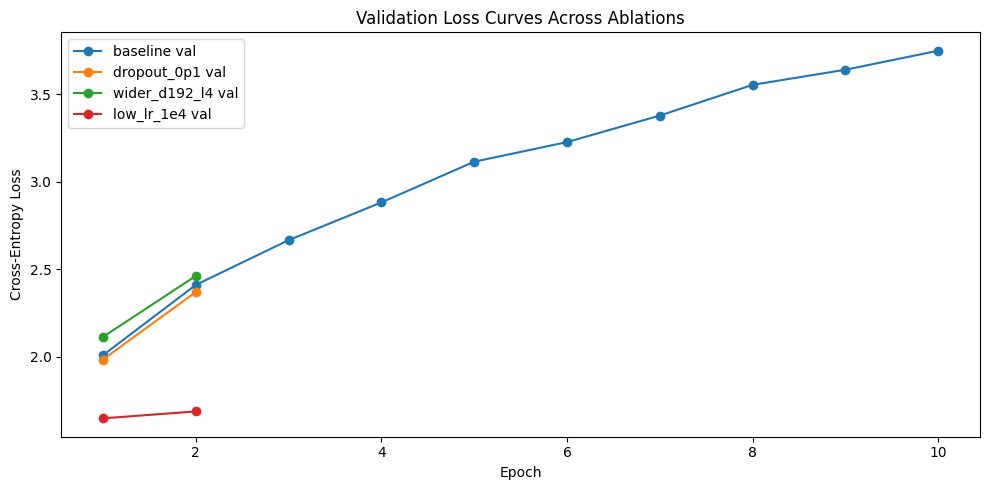

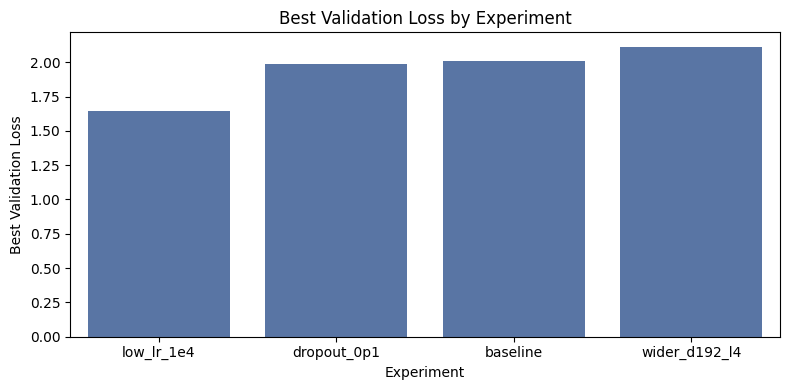

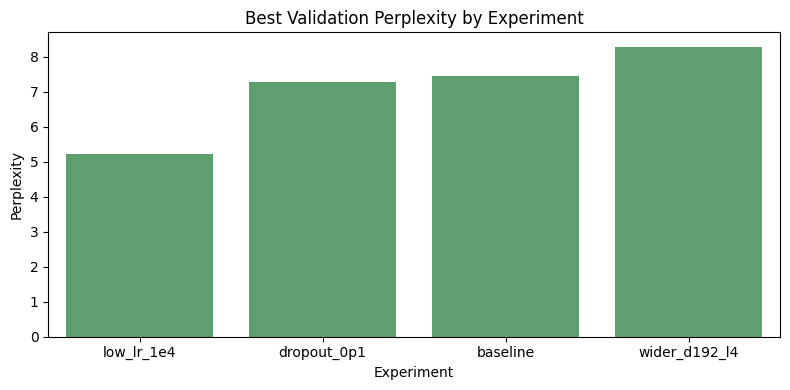

{'training_run_id': 'p5_train_seed42_20260220T064008Z', 'selected_checkpoint_path': 'data/processed/models/p5_train_seed42_20260220T064008Z_low_lr_1e4.pt', 'vocab_path': 'data/processed/models/p5_train_seed42_20260220T064008Z_vocab.json', 'stoi_path': 'data/processed/models/p5_train_seed42_20260220T064008Z_stoi.json'}


In [109]:
import time

try:
    from tqdm.auto import tqdm  # optional; falls back to plain iterator if unavailable
except Exception:
    tqdm = None


def _iter_with_progress(loader, desc, enabled=True, total=None):
    if enabled and tqdm is not None:
        kwargs = {'desc': desc, 'leave': False}
        if total is not None:
            kwargs['total'] = int(total)
        return tqdm(loader, **kwargs)
    return loader


def run_epoch(model, loader, optimizer=None, desc='epoch', max_batches=None, use_tqdm=True):
    is_train = optimizer is not None
    model.train(is_train)

    losses = []
    total_batches = len(loader)
    if total_batches == 0:
        raise ValueError(f'Loader has zero batches for {desc}. Reduce BLOCK_SIZE/BATCH_SIZE or increase token count.')

    effective_total = total_batches if max_batches is None else min(total_batches, int(max_batches))
    start_ts = time.time()
    iterator = _iter_with_progress(loader, desc=desc, enabled=use_tqdm, total=effective_total)

    for batch_idx, (x, y) in enumerate(iterator, start=1):
        x = x.to(DEVICE, non_blocking=DATALOADER_PIN_MEMORY)
        y = y.to(DEVICE, non_blocking=DATALOADER_PIN_MEMORY)
        logits = model(x)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if not torch.isfinite(loss):
            raise FloatingPointError(f'Non-finite loss detected in {desc} at batch {batch_idx}: {float(loss.detach().cpu())}')

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        losses.append(float(loss.item()))

        if tqdm is None and (batch_idx == 1 or batch_idx % 25 == 0 or batch_idx == effective_total):
            elapsed = time.time() - start_ts
            it_per_sec = batch_idx / max(elapsed, 1e-9)
            eta = (effective_total - batch_idx) / max(it_per_sec, 1e-9)
            bar_w = 24
            done = int(bar_w * batch_idx / max(effective_total, 1))
            bar = '[' + '#' * done + '-' * (bar_w - done) + ']'
            print(
                f'{desc} {bar} {batch_idx}/{effective_total} '
                f'loss={np.mean(losses):.4f} it/s={it_per_sec:.2f} eta={eta:.1f}s'
            )

        if max_batches is not None and batch_idx >= max_batches:
            break

    return float(np.mean(losses)) if losses else np.nan


# Runtime knobs (can be overridden in config cell)
USE_TQDM_PROGRESS = globals().get('USE_TQDM_PROGRESS', True)
MAX_TRAIN_BATCHES_PER_EPOCH = globals().get('MAX_TRAIN_BATCHES_PER_EPOCH', None)
MAX_VAL_BATCHES_PER_EPOCH = globals().get('MAX_VAL_BATCHES_PER_EPOCH', None)
TRAINING_BUDGET_MINUTES = globals().get('TRAINING_BUDGET_MINUTES', None)
if TRAINING_BUDGET_MINUTES in [None, 0]:
    TRAINING_BUDGET_SECONDS = None
else:
    TRAINING_BUDGET_SECONDS = float(TRAINING_BUDGET_MINUTES) * 60.0
TRAIN_GLOBAL_START = time.time()

baseline_cfg = {
    'd_model': D_MODEL,
    'n_heads': N_HEADS,
    'n_layers': N_LAYERS,
    'dropout': DROPOUT,
    'lr': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'epochs': EPOCHS,
}
experiments = [{'name': 'baseline', **baseline_cfg}]

if RUN_ABLATIONS:
    experiments.extend([
        {'name': 'dropout_0p1', **{**baseline_cfg, 'dropout': 0.1, 'epochs': ABLATION_EPOCHS}},
        {'name': 'wider_d192_l4', **{**baseline_cfg, 'd_model': 192, 'n_heads': 6, 'n_layers': 4, 'epochs': ABLATION_EPOCHS}},
        {'name': 'low_lr_1e4', **{**baseline_cfg, 'lr': 1e-4, 'epochs': ABLATION_EPOCHS}},
    ])

run_store = {}
experiment_rows = []
training_run_id = f'p5_train_seed{SEED}_{datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")}'

print({
    'device': DEVICE,
    'experiments': [e['name'] for e in experiments],
    'train_batches_per_epoch': len(train_loader),
    'val_batches_per_epoch': len(val_loader),
    'max_train_batches_per_epoch': MAX_TRAIN_BATCHES_PER_EPOCH,
    'max_val_batches_per_epoch': MAX_VAL_BATCHES_PER_EPOCH,
    'training_budget_minutes': TRAINING_BUDGET_MINUTES,
    'use_tqdm_progress': USE_TQDM_PROGRESS,
})

for exp in experiments:
    if TRAINING_BUDGET_SECONDS is not None and (time.time() - TRAIN_GLOBAL_START) >= TRAINING_BUDGET_SECONDS:
        print('Time budget reached before starting next experiment. Stopping training loop.')
        break

    name = exp['name']
    print(f'\n=== Training experiment: {name} ===')

    model_i = build_model(exp)
    optimizer_i = make_optimizer(model_i, exp)
    history = {'epoch': [], 'train_loss': [], 'val_loss': []}
    best_val = math.inf
    best_state = None

    exp_start = time.time()
    for epoch in range(1, int(exp['epochs']) + 1):
        if TRAINING_BUDGET_SECONDS is not None and (time.time() - TRAIN_GLOBAL_START) >= TRAINING_BUDGET_SECONDS:
            print(f'[{name}] time budget reached before epoch {epoch}. Ending this experiment early.')
            break

        epoch_start = time.time()
        train_loss = run_epoch(
            model_i,
            train_loader,
            optimizer=optimizer_i,
            desc=f'{name} train e{epoch}',
            max_batches=MAX_TRAIN_BATCHES_PER_EPOCH,
            use_tqdm=USE_TQDM_PROGRESS,
        )
        val_loss = run_epoch(
            model_i,
            val_loader,
            optimizer=None,
            desc=f'{name} val e{epoch}',
            max_batches=MAX_VAL_BATCHES_PER_EPOCH,
            use_tqdm=USE_TQDM_PROGRESS,
        )

        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if np.isfinite(val_loss) and val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model_i.state_dict().items()}

        print(
            f'[{name}] epoch={epoch:02d} train_loss={train_loss:.4f} '
            f'val_loss={val_loss:.4f} epoch_sec={time.time() - epoch_start:.1f}'
        )

    if len(history['epoch']) == 0:
        print(f'[{name}] no completed epochs within budget; skipping result row.')
        continue

    if best_state is not None:
        model_i.load_state_dict(best_state)

    best_ppl = float(np.exp(best_val)) if np.isfinite(best_val) else np.nan
    history_df_i = pd.DataFrame(history)

    checkpoint_path = None
    if SAVE_MODEL_CHECKPOINTS and (SAVE_ALL_ABLATION_CHECKPOINTS or name == 'baseline'):
        checkpoint_path = MODEL_DIR / f'{training_run_id}_{name}.pt'
        torch.save({
            'model_state_dict': model_i.state_dict(),
            'config': exp,
            'vocab_size': len(itos),
            'seed': SEED,
            'dataset_mode': DATASET_MODE,
            'train_fraction': TRAIN_FRACTION,
            'block_size': BLOCK_SIZE,
            'best_val_loss': best_val,
        }, checkpoint_path)

    run_store[name] = {
        'model': model_i,
        'history_df': history_df_i,
        'best_val_loss': best_val,
        'best_val_perplexity': best_ppl,
        'config': exp,
        'checkpoint_path': str(checkpoint_path) if checkpoint_path is not None else None,
    }

    experiment_rows.append({
        'experiment': name,
        'best_val_loss': best_val,
        'best_val_perplexity': best_ppl,
        'epochs': int(exp['epochs']),
        'd_model': exp['d_model'],
        'n_heads': exp['n_heads'],
        'n_layers': exp['n_layers'],
        'dropout': exp['dropout'],
        'lr': exp['lr'],
        'weight_decay': exp['weight_decay'],
        'checkpoint_path': str(checkpoint_path) if checkpoint_path is not None else None,
        'experiment_wall_sec': round(time.time() - exp_start, 2),
    })

if len(experiment_rows) == 0:
    raise RuntimeError('No experiment completed within current budget/settings. Increase TRAINING_BUDGET_MINUTES or MAX_*_BATCHES_PER_EPOCH.')

experiment_df = pd.DataFrame(experiment_rows).sort_values('best_val_loss', ascending=True).reset_index(drop=True)
display(experiment_df)

final_model_name = experiment_df.iloc[0]['experiment']
model = run_store[final_model_name]['model']
history_df = run_store[final_model_name]['history_df'].copy()
selected_checkpoint_path = run_store[final_model_name]['checkpoint_path']

print({'selected_final_model': final_model_name, 'best_val_loss': float(experiment_df.iloc[0]['best_val_loss']), 'best_val_perplexity': float(experiment_df.iloc[0]['best_val_perplexity'])})

vocab_path = MODEL_DIR / f'{training_run_id}_vocab.json'
with open(vocab_path, 'w', encoding='utf-8') as f:
    json.dump({'itos': itos}, f)
stoi_path = MODEL_DIR / f'{training_run_id}_stoi.json'
with open(stoi_path, 'w', encoding='utf-8') as f:
    json.dump(stoi, f)

if SAVE_MODEL_CHECKPOINTS and selected_checkpoint_path is None:
    selected_checkpoint_path = MODEL_DIR / f'{training_run_id}_{final_model_name}.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': run_store[final_model_name]['config'],
        'vocab_size': len(itos),
        'seed': SEED,
        'dataset_mode': DATASET_MODE,
        'train_fraction': TRAIN_FRACTION,
        'block_size': BLOCK_SIZE,
        'best_val_loss': run_store[final_model_name]['best_val_loss'],
    }, selected_checkpoint_path)
    selected_checkpoint_path = str(selected_checkpoint_path)

plt.figure(figsize=(10, 5))
for name, artifact in run_store.items():
    h = artifact['history_df']
    plt.plot(h['epoch'], h['val_loss'], marker='o', label=f'{name} val')
plt.title('Validation Loss Curves Across Ablations')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=experiment_df, x='experiment', y='best_val_loss', color='#4C72B0')
plt.title('Best Validation Loss by Experiment')
plt.xlabel('Experiment')
plt.ylabel('Best Validation Loss')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=experiment_df, x='experiment', y='best_val_perplexity', color='#55A868')
plt.title('Best Validation Perplexity by Experiment')
plt.xlabel('Experiment')
plt.ylabel('Perplexity')
plt.tight_layout()
plt.show()

print({'training_run_id': training_run_id, 'selected_checkpoint_path': selected_checkpoint_path, 'vocab_path': str(vocab_path), 'stoi_path': str(stoi_path)})


## 8B) Extended Training on Best Short-Run Model (`low_lr_1e4`)

Short-run results selected `low_lr_1e4` as strongest, so this follow-up tests whether that advantage persists when trained longer. This is a targeted extension, not a new architecture: only epoch budget changes, keeping the comparison interpretable.

In [119]:
# Extended follow-up on best short-run model
LOW_LR_EXT_EPOCHS = int(globals().get('LOW_LR_EXT_EPOCHS', 10))
LOW_LR_EXT_NAME = globals().get('LOW_LR_EXT_NAME', 'low_lr_1e4_ext10')
RUN_LOW_LR_EXT = bool(globals().get('RUN_LOW_LR_EXT', True))

if not RUN_LOW_LR_EXT:
    print('Skipping 8B extended training (RUN_LOW_LR_EXT=False).')
elif 'low_lr_1e4' not in run_store:
    print('Skipping 8B: low_lr_1e4 experiment not available in run_store.')
else:
    base_cfg = dict(run_store['low_lr_1e4']['config'])
    ext_cfg = {**base_cfg, 'epochs': LOW_LR_EXT_EPOCHS}

    print({'extended_experiment': LOW_LR_EXT_NAME, 'epochs': LOW_LR_EXT_EPOCHS, 'base_cfg': base_cfg})

    model_ext = build_model(ext_cfg)
    optimizer_ext = make_optimizer(model_ext, ext_cfg)

    history_ext = {'epoch': [], 'train_loss': [], 'val_loss': []}
    best_val_ext = math.inf
    best_state_ext = None

    ext_start = time.time()
    for epoch in range(1, LOW_LR_EXT_EPOCHS + 1):
        train_loss = run_epoch(
            model_ext,
            train_loader,
            optimizer=optimizer_ext,
            desc=f'{LOW_LR_EXT_NAME} train e{epoch}',
            max_batches=MAX_TRAIN_BATCHES_PER_EPOCH,
            use_tqdm=USE_TQDM_PROGRESS,
        )
        val_loss = run_epoch(
            model_ext,
            val_loader,
            optimizer=None,
            desc=f'{LOW_LR_EXT_NAME} val e{epoch}',
            max_batches=MAX_VAL_BATCHES_PER_EPOCH,
            use_tqdm=USE_TQDM_PROGRESS,
        )

        history_ext['epoch'].append(epoch)
        history_ext['train_loss'].append(train_loss)
        history_ext['val_loss'].append(val_loss)

        if np.isfinite(val_loss) and val_loss < best_val_ext:
            best_val_ext = val_loss
            best_state_ext = {k: v.detach().cpu().clone() for k, v in model_ext.state_dict().items()}

        print(f'[{LOW_LR_EXT_NAME}] epoch={epoch:02d} train_loss={train_loss:.4f} val_loss={val_loss:.4f}')

    if best_state_ext is not None:
        model_ext.load_state_dict(best_state_ext)

    best_ppl_ext = float(np.exp(best_val_ext)) if np.isfinite(best_val_ext) else np.nan
    history_df_ext = pd.DataFrame(history_ext)

    checkpoint_ext = None
    if SAVE_MODEL_CHECKPOINTS:
        checkpoint_ext = MODEL_DIR / f'{training_run_id}_{LOW_LR_EXT_NAME}.pt'
        torch.save({
            'model_state_dict': model_ext.state_dict(),
            'config': ext_cfg,
            'vocab_size': len(itos),
            'seed': SEED,
            'dataset_mode': DATASET_MODE,
            'train_fraction': TRAIN_FRACTION,
            'block_size': BLOCK_SIZE,
            'best_val_loss': best_val_ext,
        }, checkpoint_ext)

    run_store[LOW_LR_EXT_NAME] = {
        'model': model_ext,
        'history_df': history_df_ext,
        'best_val_loss': best_val_ext,
        'best_val_perplexity': best_ppl_ext,
        'config': ext_cfg,
        'checkpoint_path': str(checkpoint_ext) if checkpoint_ext is not None else None,
    }

    ext_row = {
        'experiment': LOW_LR_EXT_NAME,
        'best_val_loss': best_val_ext,
        'best_val_perplexity': best_ppl_ext,
        'epochs': int(ext_cfg['epochs']),
        'd_model': ext_cfg['d_model'],
        'n_heads': ext_cfg['n_heads'],
        'n_layers': ext_cfg['n_layers'],
        'dropout': ext_cfg['dropout'],
        'lr': ext_cfg['lr'],
        'weight_decay': ext_cfg['weight_decay'],
        'checkpoint_path': str(checkpoint_ext) if checkpoint_ext is not None else None,
        'experiment_wall_sec': round(time.time() - ext_start, 2),
    }

    # upsert row in experiment_df
    experiment_df = experiment_df[experiment_df['experiment'] != LOW_LR_EXT_NAME].copy()
    experiment_df = pd.concat([experiment_df, pd.DataFrame([ext_row])], ignore_index=True)
    experiment_df = experiment_df.sort_values('best_val_loss', ascending=True).reset_index(drop=True)

    # re-bind final selected model for downstream cells
    final_model_name = experiment_df.iloc[0]['experiment']
    model = run_store[final_model_name]['model']
    history_df = run_store[final_model_name]['history_df'].copy()
    selected_checkpoint_path = run_store[final_model_name]['checkpoint_path']

    display(experiment_df)
    print({
        'post_8b_selected_final_model': final_model_name,
        'best_val_loss': float(experiment_df.iloc[0]['best_val_loss']),
        'best_val_perplexity': float(experiment_df.iloc[0]['best_val_perplexity']),
    })


{'extended_experiment': 'low_lr_1e4_ext10', 'epochs': 10, 'base_cfg': {'name': 'low_lr_1e4', 'd_model': 128, 'n_heads': 4, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.0001, 'weight_decay': 0.0001, 'epochs': 2}}


low_lr_1e4_ext10 train e1:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e1:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=01 train_loss=2.3647 val_loss=1.6410


low_lr_1e4_ext10 train e2:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e2:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=02 train_loss=1.1818 val_loss=1.6852


low_lr_1e4_ext10 train e3:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e3:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=03 train_loss=0.9770 val_loss=1.7585


low_lr_1e4_ext10 train e4:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e4:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=04 train_loss=0.8368 val_loss=1.8370


low_lr_1e4_ext10 train e5:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e5:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=05 train_loss=0.7337 val_loss=1.9348


low_lr_1e4_ext10 train e6:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e6:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=06 train_loss=0.6598 val_loss=2.0371


low_lr_1e4_ext10 train e7:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e7:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=07 train_loss=0.6065 val_loss=2.1225


low_lr_1e4_ext10 train e8:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e8:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=08 train_loss=0.5666 val_loss=2.2167


low_lr_1e4_ext10 train e9:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e9:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=09 train_loss=0.5355 val_loss=2.3012


low_lr_1e4_ext10 train e10:   0%|          | 0/2109 [00:00<?, ?it/s]

low_lr_1e4_ext10 val e10:   0%|          | 0/234 [00:00<?, ?it/s]

[low_lr_1e4_ext10] epoch=10 train_loss=0.5105 val_loss=2.3791


,experiment,best_val_loss,best_val_perplexity,epochs,d_model,n_heads,n_layers,dropout,lr,weight_decay,checkpoint_path,experiment_wall_sec
0,low_lr_1e4_ext10,1.640967,5.160158,10,128,4,2,0.2,0.0001,0.0001,data/processed/models/p5_train_seed42_20260220...,2134.35
1,low_lr_1e4,1.648972,5.201631,2,128,4,2,0.2,0.0001,0.0001,None,425.50
2,dropout_0p1,1.984610,7.276208,2,128,4,2,0.1,0.0010,0.0001,None,427.77
3,baseline,2.009012,7.455945,10,128,4,2,0.2,0.0010,0.0001,data/processed/models/p5_train_seed42_20260220...,2142.43
4,wider_d192_l4,2.113552,8.277588,2,192,6,4,0.2,0.0010,0.0001,None,881.86


{'post_8b_selected_final_model': 'low_lr_1e4_ext10', 'best_val_loss': 1.6409672717126007, 'best_val_perplexity': 5.160158374281124}


The extended run confirms the same early-epoch behavior seen in earlier experiments: `low_lr_1e4_ext10` reaches its best validation loss near the start (about 1.641 at epoch 1) and then drifts upward with additional epochs. Since this model still ranks first overall (about 18.32% better best-loss than baseline), the next step is to persist checkpoints and metadata so downstream generation and RCA are tied to a traceable selected artifact.

In [120]:
from pathlib import Path
import shutil, json
import torch

# Prefer Drive if available, otherwise persist locally under PROCESSED_DIR/models
candidate_persist_dirs = [
    Path('/content/drive/MyDrive/data processed 2017/models'),
    Path('/content/drive/data processed 2017/models'),
    MODEL_DIR,
]

PERSIST_DIR = None
for d in candidate_persist_dirs:
    try:
        d.mkdir(parents=True, exist_ok=True)
        PERSIST_DIR = d
        break
    except Exception:
        continue

if PERSIST_DIR is None:
    PERSIST_DIR = MODEL_DIR
    PERSIST_DIR.mkdir(parents=True, exist_ok=True)

saved = []

# Save selected model explicitly
final_ckpt = PERSIST_DIR / f"{training_run_id}_{final_model_name}_selected.pt"
torch.save({
    "model_state_dict": model.state_dict(),
    "config": run_store[final_model_name]["config"],
    "seed": SEED,
    "dataset_mode": DATASET_MODE,
    "best_val_loss": run_store[final_model_name]["best_val_loss"],
}, final_ckpt)
saved.append(str(final_ckpt))

# Copy experiment checkpoints if they exist
for name, art in run_store.items():
    cp = art.get("checkpoint_path")
    if cp and Path(cp).exists():
        dst = PERSIST_DIR / Path(cp).name
        if str(Path(cp).resolve()) != str(dst.resolve()):
            shutil.copy2(cp, dst)
        saved.append(str(dst))

# Save vocab/stoi/history
with open(PERSIST_DIR / f"{training_run_id}_vocab.json", "w", encoding="utf-8") as f:
    json.dump({"itos": itos}, f)
with open(PERSIST_DIR / f"{training_run_id}_stoi.json", "w", encoding="utf-8") as f:
    json.dump(stoi, f)
experiment_df.to_csv(PERSIST_DIR / f"{training_run_id}_experiment_df.csv", index=False)

print("Persisted artifacts directory:", PERSIST_DIR)
print("Persisted artifacts count:", len(saved))
for s in saved:
    print(" -", s)


Persisted artifacts directory: /content/drive/MyDrive/data processed 2017/models
Persisted artifacts count: 3
 - /content/drive/MyDrive/data processed 2017/models/p5_train_seed42_20260220T064008Z_low_lr_1e4_ext10_selected.pt
 - /content/drive/MyDrive/data processed 2017/models/p5_train_seed42_20260220T064008Z_baseline.pt
 - /content/drive/MyDrive/data processed 2017/models/p5_train_seed42_20260220T064008Z_low_lr_1e4_ext10.pt


### Analysis

Training shows clear overfitting in higher-rate settings: baseline validation loss is best at epoch 1 (~2.009) and then worsens to ~3.747 by epoch 10. In short ablations, `low_lr_1e4` achieved the best initial validation loss (~1.649), and 8B improved it slightly to ~1.641 (`low_lr_1e4_ext10`), with best performance still occurring early before later-epoch degradation. This supports using the low-learning-rate family for downstream generation while documenting overfitting risk as a core limitation.

### Benchmark Visualization

The benchmark plots summarize trajectory and ranking outcomes across experiments. They are intended to show both absolute fit quality (best validation loss/perplexity) and relative effect size against baseline, not just a single selected-model metric.

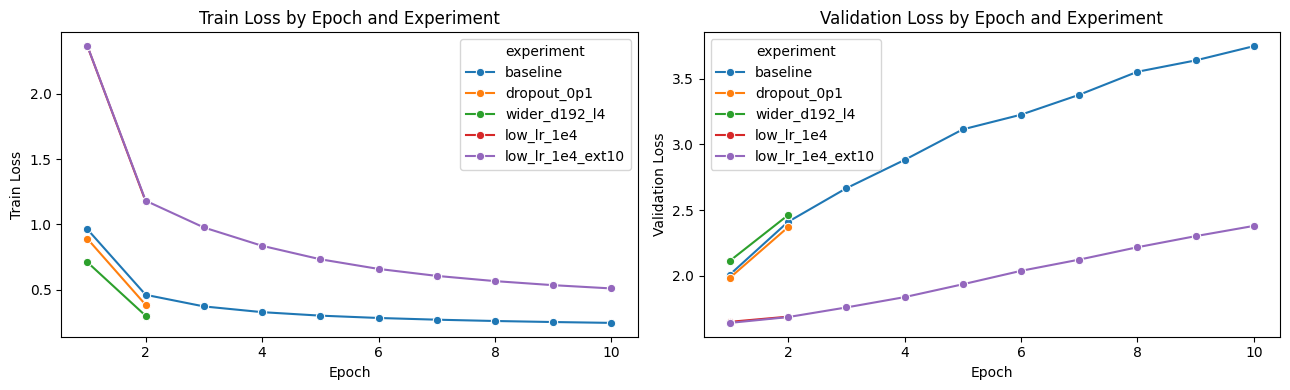

,experiment,best_val_loss,best_val_perplexity,relative_improvement_vs_baseline_pct
0,low_lr_1e4_ext10,1.640967,5.160158,18.319673
1,low_lr_1e4,1.648972,5.201631,17.921217
2,dropout_0p1,1.984610,7.276208,1.214620
3,baseline,2.009012,7.455945,0.000000
4,wider_d192_l4,2.113552,8.277588,-5.203550


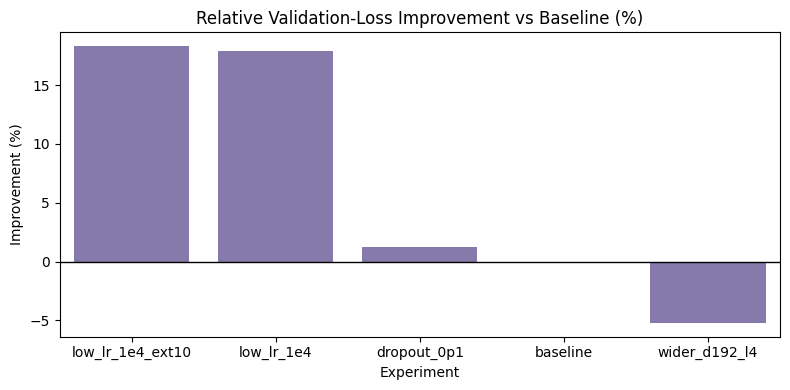

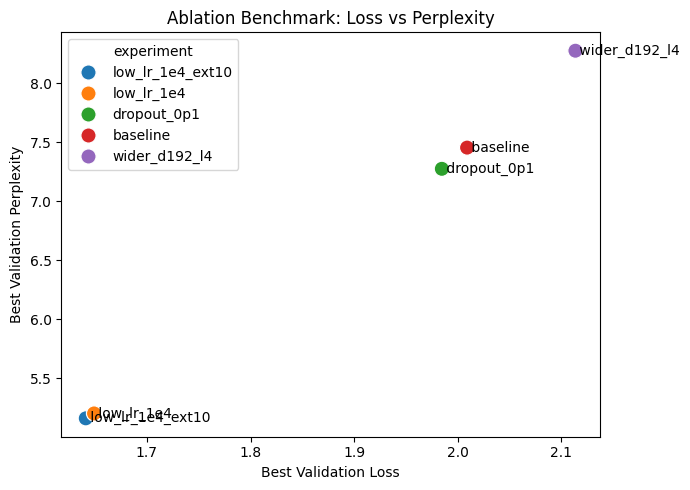

In [121]:
# Build a long-form history table for trajectory comparisons
history_rows = []
for exp_name, artifact in run_store.items():
    h = artifact['history_df'].copy()
    h['experiment'] = exp_name
    history_rows.append(h)

history_long_df = pd.concat(history_rows, ignore_index=True) if history_rows else pd.DataFrame()

if len(history_long_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    sns.lineplot(data=history_long_df, x='epoch', y='train_loss', hue='experiment', marker='o', ax=axes[0])
    axes[0].set_title('Train Loss by Epoch and Experiment')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Train Loss')

    sns.lineplot(data=history_long_df, x='epoch', y='val_loss', hue='experiment', marker='o', ax=axes[1])
    axes[1].set_title('Validation Loss by Epoch and Experiment')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')

    plt.tight_layout()
    plt.show()

# Relative improvement over baseline
bench_df = experiment_df.copy()
baseline_loss = float(bench_df.loc[bench_df['experiment'] == 'baseline', 'best_val_loss'].iloc[0]) if (bench_df['experiment'] == 'baseline').any() else float(bench_df['best_val_loss'].iloc[0])
bench_df['relative_improvement_vs_baseline_pct'] = 100.0 * (baseline_loss - bench_df['best_val_loss']) / baseline_loss

display(bench_df[['experiment', 'best_val_loss', 'best_val_perplexity', 'relative_improvement_vs_baseline_pct']])

plt.figure(figsize=(8, 4))
sns.barplot(data=bench_df, x='experiment', y='relative_improvement_vs_baseline_pct', color='#8172B2')
plt.axhline(0.0, color='black', linewidth=1)
plt.title('Relative Validation-Loss Improvement vs Baseline (%)')
plt.xlabel('Experiment')
plt.ylabel('Improvement (%)')
plt.tight_layout()
plt.show()

# Joint metric view
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(data=bench_df, x='best_val_loss', y='best_val_perplexity', hue='experiment', s=120)
for _, row in bench_df.iterrows():
    ax.text(row['best_val_loss'], row['best_val_perplexity'], f" {row['experiment']}", va='center')
plt.title('Ablation Benchmark: Loss vs Perplexity')
plt.xlabel('Best Validation Loss')
plt.ylabel('Best Validation Perplexity')
plt.tight_layout()
plt.show()


## 9) Generate Event Sequences

Sequence generation uses the selected final model (`low_lr_1e4_ext10` in this run), with temperature/top-k sampling and repetition controls. The aim is to produce enough variation for RCA scoring while preventing trivial token loops.

In [122]:
def sample_next_token(logits, temperature=1.0, top_k=25, generated_ids=None, repetition_penalty=1.0, no_repeat_last_n=0):
    adjusted = logits.clone()

    # Repetition penalty against recently used tokens
    if generated_ids is not None and repetition_penalty is not None and repetition_penalty > 1.0:
        recent = generated_ids[-int(no_repeat_last_n):] if (no_repeat_last_n is not None and no_repeat_last_n > 0) else generated_ids
        for tid in set(recent):
            if 0 <= int(tid) < adjusted.shape[-1]:
                adjusted[int(tid)] = adjusted[int(tid)] / float(repetition_penalty)

    adjusted = adjusted / max(float(temperature), 1e-6)

    if top_k is not None and top_k > 0:
        k = min(int(top_k), adjusted.shape[-1])
        top_vals, top_idx = torch.topk(adjusted, k=k)
        probs = torch.softmax(top_vals, dim=-1)
        choice = torch.multinomial(probs, num_samples=1)
        return top_idx[choice]

    probs = torch.softmax(adjusted, dim=-1)
    return torch.multinomial(probs, num_samples=1)


def generate_tokens(model, seed_tokens, max_new_tokens=120, temperature=0.9, top_k=25, repetition_penalty=1.0, no_repeat_last_n=0):
    model.eval()
    tokens = seed_tokens.copy()
    x = torch.tensor(tokens, dtype=torch.long, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            x_ctx = x[:, -BLOCK_SIZE:]
            logits = model(x_ctx)
            next_logits = logits[0, -1, :]
            next_token = sample_next_token(
                next_logits,
                temperature=temperature,
                top_k=top_k,
                generated_ids=tokens,
                repetition_penalty=repetition_penalty,
                no_repeat_last_n=no_repeat_last_n,
            )
            x = torch.cat([x, next_token.view(1, 1)], dim=1)
            tokens.append(int(next_token.item()))

    return x.squeeze(0).cpu().tolist()


def decode_tokens(token_ids):
    return [itos[t] if 0 <= t < len(itos) else '<UNK>' for t in token_ids]


def split_events(decoded_tokens):
    events = []
    cur = []
    for tok in decoded_tokens:
        if tok == '<EOS>':
            if cur:
                events.append(cur)
                cur = []
        elif tok not in {'<PAD>'}:
            cur.append(tok)
    if cur:
        events.append(cur)
    return events


seed_start = random.randint(0, max(1, len(train_tokens) - BLOCK_SIZE - 1))
seed_seq = train_tokens[seed_start: seed_start + BLOCK_SIZE].tolist()

generated_samples = []
for i in range(NUM_GENERATIONS):
    token_ids = generate_tokens(
        model,
        seed_tokens=seed_seq,
        max_new_tokens=GEN_MAX_NEW_TOKENS,
        temperature=GEN_TEMPERATURE,
        top_k=GEN_TOP_K,
        repetition_penalty=REPETITION_PENALTY,
        no_repeat_last_n=NO_REPEAT_LAST_N,
    )
    decoded = decode_tokens(token_ids)
    events = split_events(decoded)

    generated_samples.append({
        'generation_id': f'gen_{i+1:02d}',
        'token_ids': token_ids,
        'decoded_tokens': decoded,
        'events': events,
    })

print('Generated samples:', len(generated_samples))
for s in generated_samples[:2]:
    print()
    print(s['generation_id'], 'event_count=', len(s['events']))
    for ev in s['events'][:3]:
        print('  ', ' '.join(ev))

Generated samples: 8

gen_01 event_count= 14
   DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15
   TB_398 SC_256 DC_234 PR_6 SP_Port05116 DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15
   TB_398 SC_256 DC_234 PR_6 SP_Port05116 DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15

gen_02 event_count= 14
   DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15
   TB_398 SC_256 DC_234 PR_6 SP_Port05116 DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15
   TB_398 SC_256 DC_234 PR_6 SP_Port05116 DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15


### Analysis

Eight samples were generated, typically with 14?15 parsed events each. Diversity improved compared with earlier runs, but repeated structural motifs remain visible in early events. This is sufficient for RCA hypothesis testing, though the model still favors dominant flow templates from the training distribution.

## 10) RCA Narrative Layer Over Generated Events

RCA is implemented as a scored interpretation layer over generated events: repetition, destination spread, protocol rarity, and burstiness are combined into a confidence-weighted hypothesis. This keeps conclusions traceable to explicit features rather than opaque free-text generation.

In [123]:
def tokens_to_event_dict(token_list):
    d = {}
    for tok in token_list:
        if '_' not in tok:
            continue
        prefix = tok.split('_', 1)[0]
        d[prefix] = tok
    return d


def _extract_num(tok, default=np.nan):
    if tok is None:
        return default
    m = re.search(r'(-?\d+)', str(tok))
    return float(m.group(1)) if m else default


def _safe_std(x):
    x = [v for v in x if pd.notna(v)]
    if len(x) < 2:
        return 0.0
    return float(np.std(x))


def _protocol_rarity_score(proto_counts, p_tok):
    # rarity = 1 - empirical frequency in source data
    total = max(sum(proto_counts.values()), 1)
    p = proto_counts.get(p_tok, 0) / total
    return float(1.0 - p)


def _build_wls_lookup(df):
    if df is None or len(df) == 0:
        return {}
    if 'timestamp' not in df.columns:
        return {}
    ts = pd.to_numeric(df['timestamp'], errors='coerce')
    tb = (ts // TIME_BIN_SECONDS).astype('Int64')
    tmp = df.copy()
    tmp['tb'] = tb
    out = {}
    for k, g in tmp.dropna(subset=['tb']).groupby('tb'):
        out[int(k)] = {
            'rows': int(len(g)),
            'top_event_ids': g['event_id'].astype(str).value_counts().head(3).index.tolist() if 'event_id' in g.columns else [],
            'top_computers': g['computer'].astype(str).value_counts().head(3).index.tolist() if 'computer' in g.columns else [],
        }
    return out


WLS_LOOKUP = _build_wls_lookup(wls_context_df if 'wls_context_df' in globals() else None)
RAW_PROTO_COUNTS = Counter(raw_df['protocol'].astype(str).tolist()) if 'protocol' in raw_df.columns else Counter()


def summarize_generated_events(events):
    parsed = [tokens_to_event_dict(ev) for ev in events]
    if not parsed:
        return {
            'generated_summary': 'No coherent events generated.',
            'rca_hypothesis': 'Model output too short for RCA hypothesis.',
            'rca_confidence': 0.0,
            'score_repetition': 1.0,
            'score_dst_spread': 0.0,
            'score_proto_rarity': 0.0,
            'score_burstiness': 0.0,
            'evidence_refs': [],
            'quality_flags': ['empty_generation'],
            'safety_flags': ['human_review_required'],
            'failure_mode_tags': ['insufficient_content'],
        }

    src_counts = Counter([p.get('SC', 'SC_UNK') for p in parsed])
    dst_counts = Counter([p.get('DC', 'DC_UNK') for p in parsed])
    proto_counts = Counter([p.get('PR', 'PR_UNK') for p in parsed])

    top_src, top_src_n = src_counts.most_common(1)[0]
    top_dst, top_dst_n = dst_counts.most_common(1)[0]
    top_proto, top_proto_n = proto_counts.most_common(1)[0]

    total = len(parsed)
    unique_dst = len(dst_counts)
    dst_spread_ratio = unique_dst / max(total, 1)

    # repetition score from repeated event signatures
    signatures = ['|'.join(sorted(ev)) for ev in events if len(ev) > 0]
    sig_unique = len(set(signatures))
    repetition_ratio = 1.0 - (sig_unique / max(len(signatures), 1))

    # burstiness from DU/SPK/DBY token variation
    du_vals = [_extract_num(p.get('DU')) for p in parsed]
    spk_vals = [_extract_num(p.get('SPK')) for p in parsed]
    dby_vals = [_extract_num(p.get('DBY')) for p in parsed]
    burstiness = min(1.0, (_safe_std(du_vals) + _safe_std(spk_vals) + _safe_std(dby_vals)) / 10.0)

    proto_rarity = _protocol_rarity_score(RAW_PROTO_COUNTS, top_proto.replace('PR_', ''))

    # Weighted anomaly score
    score_repetition = float(repetition_ratio)
    score_dst_spread = float(dst_spread_ratio)
    score_proto_rarity = float(proto_rarity)
    score_burstiness = float(burstiness)

    composite = (
        0.40 * score_repetition
        + 0.25 * score_dst_spread
        + 0.20 * score_proto_rarity
        + 0.15 * score_burstiness
    )
    confidence = float(np.clip(composite, 0.0, 1.0))

    quality_flags = []
    failure_tags = []

    if score_repetition > 0.70:
        quality_flags.append('high_repetition')
    if score_dst_spread > 0.65:
        quality_flags.append('high_destination_spread')
    if score_proto_rarity > 0.85:
        quality_flags.append('rare_protocol_pattern')
    if total < 6:
        failure_tags.append('short_sequence')

    if score_repetition > 0.70 and score_dst_spread < 0.40:
        rca = 'Automated repetitive flow loop; likely periodic/service-driven traffic with low path diversity.'
    elif score_dst_spread > 0.65 and score_proto_rarity > 0.75:
        rca = 'Potential fan-out reconnaissance pattern with uncommon protocol concentration.'
    elif score_burstiness > 0.60:
        rca = 'Burst-style throughput transitions suggest unstable traffic phase or short-lived flood behavior.'
    else:
        rca = 'Predominantly structured network-flow pattern with moderate variability and limited anomaly strength.'

    # WLS grounding by generated time buckets
    tb_vals = sorted({int(_extract_num(p.get('TB'), default=np.nan)) for p in parsed if pd.notna(_extract_num(p.get('TB'), default=np.nan))})
    wls_hits = []
    for tb in tb_vals[:6]:
        if tb in WLS_LOOKUP:
            w = WLS_LOOKUP[tb]
            wls_hits.append({
                'type': 'wls_context',
                'tb': int(tb),
                'rows': int(w.get('rows', 0)),
                'top_event_ids': w.get('top_event_ids', []),
                'top_computers': w.get('top_computers', []),
            })

    evidence_refs = [{'type': 'generated_event_index', 'value': int(i)} for i in range(min(5, total))]
    evidence_refs.extend(wls_hits)

    summary = (
        f'Generated {total} events. Dominant source {top_src} ({top_src_n}), '
        f'dominant destination {top_dst} ({top_dst_n}), dominant protocol {top_proto} ({top_proto_n}). '
        f'Scores: repetition={score_repetition:.3f}, dst_spread={score_dst_spread:.3f}, '
        f'proto_rarity={score_proto_rarity:.3f}, burstiness={score_burstiness:.3f}, confidence={confidence:.3f}. '
        f'WLS_hits={len(wls_hits)}.'
    )

    safety_flags = ['generated_not_ground_truth', 'human_validation_required', 'cross_source_validation_recommended']

    return {
        'generated_summary': summary,
        'rca_hypothesis': rca,
        'rca_confidence': confidence,
        'score_repetition': score_repetition,
        'score_dst_spread': score_dst_spread,
        'score_proto_rarity': score_proto_rarity,
        'score_burstiness': score_burstiness,
        'evidence_refs': evidence_refs,
        'quality_flags': quality_flags,
        'safety_flags': safety_flags,
        'failure_mode_tags': failure_tags,
    }


rca_rows = []
for sample in generated_samples:
    interp = summarize_generated_events(sample['events'])
    row = {
        'generation_id': sample['generation_id'],
        'event_count': len(sample['events']),
        **interp,
    }
    rca_rows.append(row)

rca_df = pd.DataFrame(rca_rows)
display(rca_df[[
    'generation_id', 'event_count', 'rca_confidence', 'score_repetition',
    'score_dst_spread', 'score_proto_rarity', 'score_burstiness',
    'rca_hypothesis', 'quality_flags', 'failure_mode_tags'
]])


,generation_id,event_count,rca_confidence,score_repetition,score_dst_spread,score_proto_rarity,score_burstiness,rca_hypothesis,quality_flags,failure_mode_tags
0,gen_01,14,0.355877,0.214286,0.428571,0.729527,0.114095,Predominantly structured network-flow pattern ...,[],[]
1,gen_02,14,0.455233,0.285714,0.428571,0.729527,0.585994,Predominantly structured network-flow pattern ...,[],[]
2,gen_03,14,0.433196,0.214286,0.428571,0.729527,0.629557,Burst-style throughput transitions suggest uns...,[],[]
3,gen_04,14,0.375210,0.214286,0.428571,0.729527,0.242987,Predominantly structured network-flow pattern ...,[],[]
4,gen_05,14,0.454568,0.214286,0.571429,0.729527,0.533942,Predominantly structured network-flow pattern ...,[],[]
5,gen_06,15,0.445825,0.200000,0.466667,0.729527,0.688354,Burst-style throughput transitions suggest uns...,[],[]
6,gen_07,14,0.427994,0.214286,0.500000,0.729527,0.475827,Predominantly structured network-flow pattern ...,[],[]
7,gen_08,14,0.357257,0.214286,0.357143,0.729527,0.242343,Predominantly structured network-flow pattern ...,[],[]


### Analysis

RCA confidence ranges roughly from 0.356 to 0.455 in this run, with protocol rarity consistently high and destination-spread/burstiness driving differences between generations. Most hypotheses remain in a structured-pattern class, while a subset is labeled as burst-style transitions. Empty quality/failure flags indicate coherent parsing but also show that anomaly thresholds are conservative.

## 11) Graph Views of Generated Interactions and RCA Links

Graph views compress sequence-level outputs into interaction structure and RCA linkage patterns. They help detect whether generated behavior is dominated by a few hubs/edges or captures broader path variability across samples.

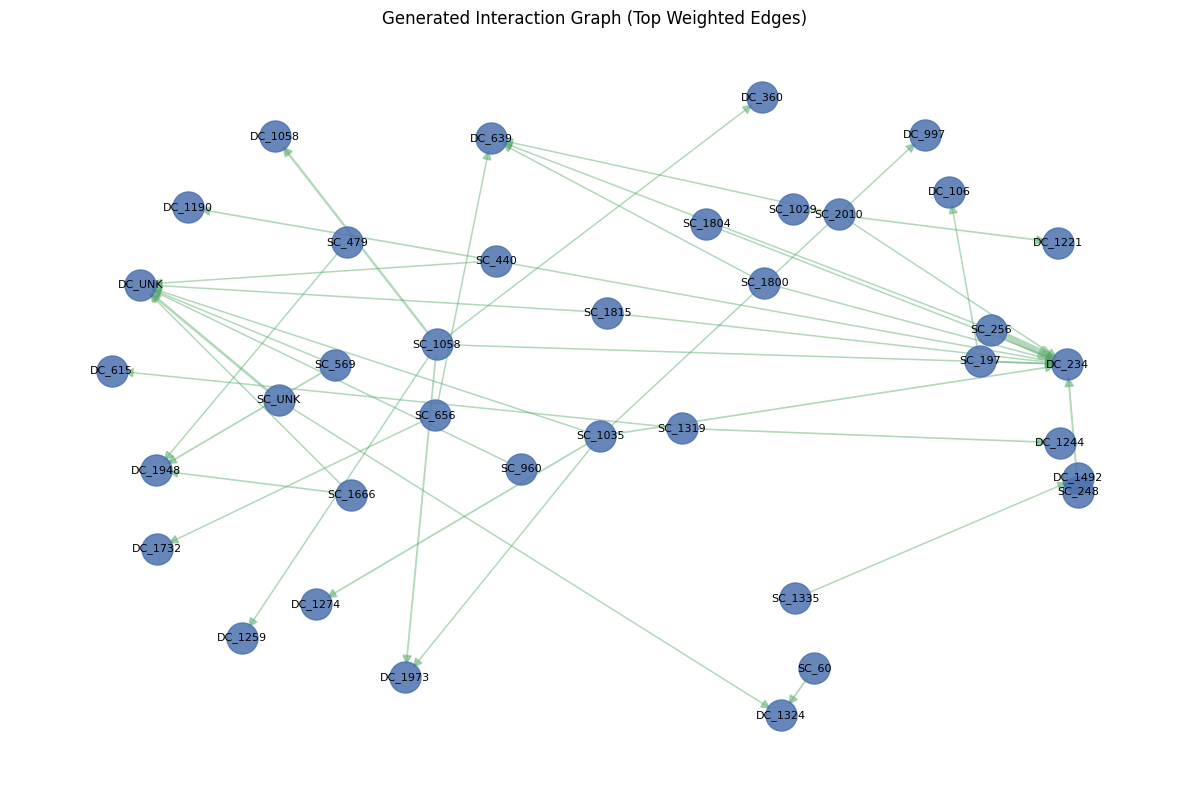

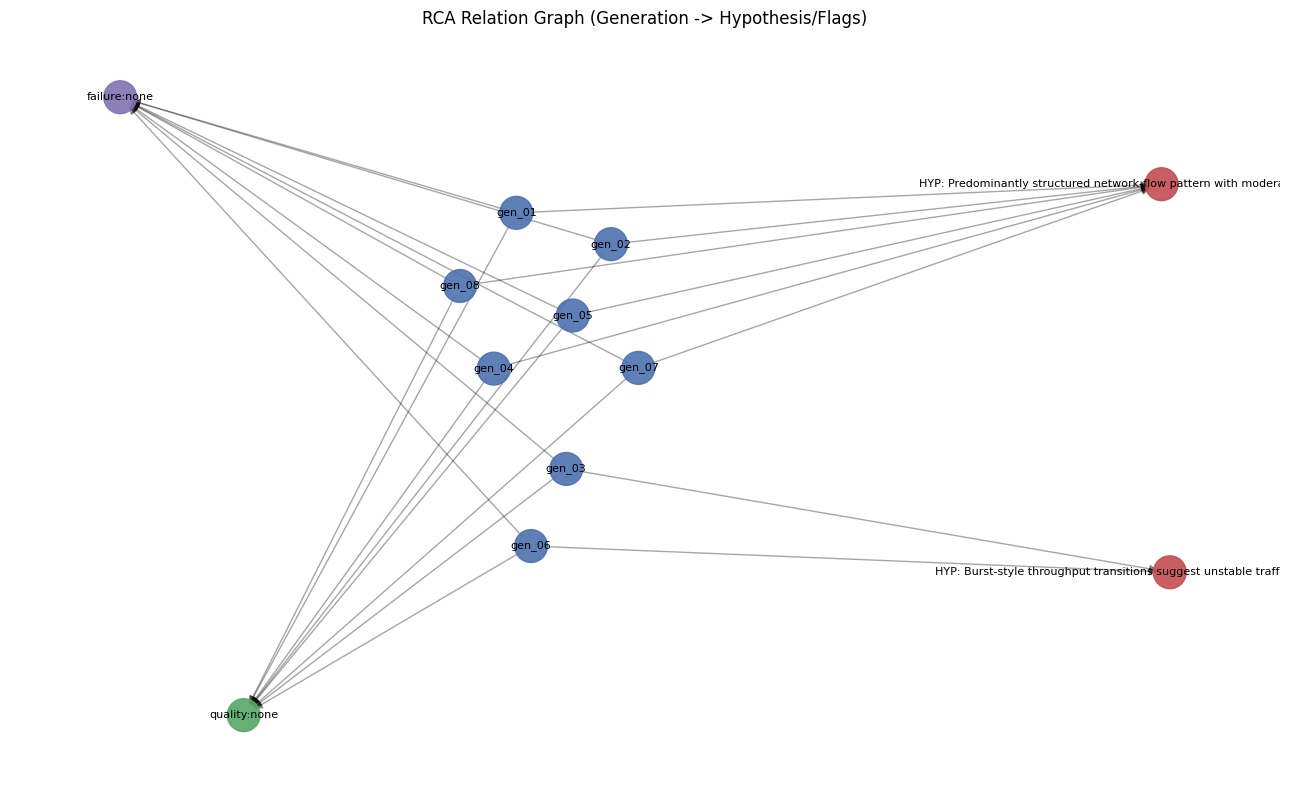

In [124]:
# Graph 1: generated interaction graph (aggregated across samples)
interaction_edges = Counter()
for sample in generated_samples:
    for ev in sample['events']:
        d = tokens_to_event_dict(ev)
        src = d.get('SC', 'SC_UNK')
        dst = d.get('DC', 'DC_UNK')
        interaction_edges[(src, dst)] += 1

# keep top edges for readability
top_k_edges = 40
top_edges = interaction_edges.most_common(top_k_edges)

G = nx.DiGraph()
for (src, dst), w in top_edges:
    G.add_edge(src, dst, weight=w)

plt.figure(figsize=(12, 8))
if G.number_of_nodes() > 0:
    pos = nx.spring_layout(G, seed=SEED, k=0.7)
    edge_w = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(edge_w) if edge_w else 1
    edge_w_norm = [1 + 4 * (w / max_w) for w in edge_w]

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='#4C72B0', alpha=0.85)
    nx.draw_networkx_edges(G, pos, width=edge_w_norm, alpha=0.45, edge_color='#55A868', arrows=True, arrowsize=14)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title('Generated Interaction Graph (Top Weighted Edges)')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No graph edges available', ha='center', va='center')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Graph 2: RCA relation graph (generation -> hypothesis/flags)
R = nx.DiGraph()
for row in rca_rows:
    gen = row['generation_id']
    hyp = f"HYP: {row['rca_hypothesis'][:80]}"
    R.add_edge(gen, hyp, rel='hypothesis')

    qf = row.get('quality_flags', []) or []
    if len(qf) == 0:
        R.add_edge(gen, 'quality:none', rel='quality')
    else:
        for q in qf:
            R.add_edge(gen, f'quality:{q}', rel='quality')

    ff = row.get('failure_mode_tags', []) or []
    if len(ff) == 0:
        R.add_edge(gen, 'failure:none', rel='failure')
    else:
        for ftag in ff:
            R.add_edge(gen, f'failure:{ftag}', rel='failure')

plt.figure(figsize=(13, 8))
if R.number_of_nodes() > 0:
    pos = nx.spring_layout(R, seed=SEED, k=0.9)
    node_colors = []
    for n in R.nodes():
        if str(n).startswith('gen_'):
            node_colors.append('#4C72B0')
        elif str(n).startswith('HYP:'):
            node_colors.append('#C44E52')
        elif str(n).startswith('quality:'):
            node_colors.append('#55A868')
        else:
            node_colors.append('#8172B2')

    nx.draw_networkx_nodes(R, pos, node_size=560, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(R, pos, alpha=0.35, arrows=True, arrowsize=12)
    nx.draw_networkx_labels(R, pos, font_size=8)
    plt.title('RCA Relation Graph (Generation -> Hypothesis/Flags)')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No RCA graph edges available', ha='center', va='center')
    plt.axis('off')
plt.tight_layout()
plt.show()


### Analysis

The generated interaction graph and RCA linkage graph render stable structures with recurring hubs, consistent with the moderate repetition seen in token diagnostics. The graphs support the same conclusion as the numeric metrics: useful structure is present, but diversity is still bounded.

## 12) Generation Quality Diagnostics

These diagnostics quantify generation quality using distinct-n and repetition metrics so interpretation is evidence-based. They are especially important when validation loss is good but outputs may still collapse toward frequent templates.

,generation_id,token_count,distinct_1,distinct_2,repetition_ratio,eos_count
0,gen_01,160,0.24375,0.383648,0.75625,13
1,gen_02,160,0.30625,0.465409,0.69375,13
2,gen_03,160,0.33750,0.484277,0.66250,13
3,gen_04,160,0.25000,0.396226,0.75000,14
4,gen_05,160,0.28125,0.452830,0.71875,13
5,gen_06,160,0.36250,0.528302,0.63750,14
6,gen_07,160,0.29375,0.427673,0.70625,13
7,gen_08,160,0.26875,0.408805,0.73125,13


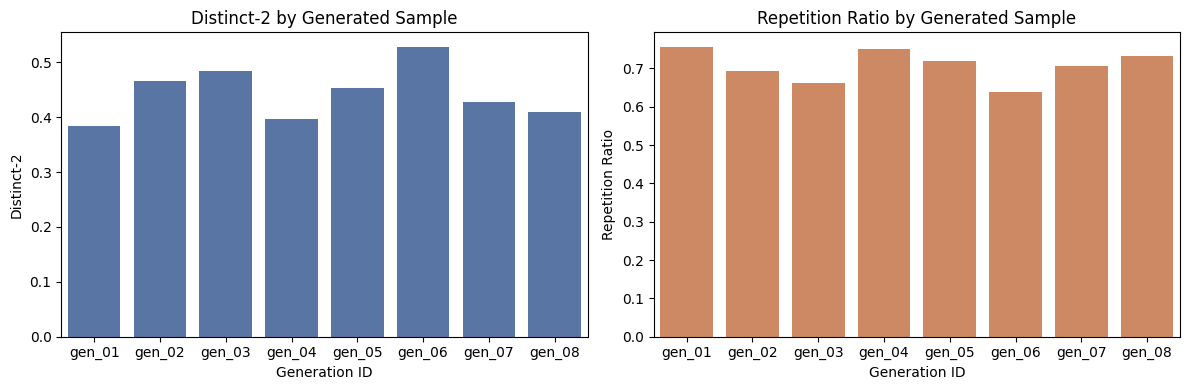

In [125]:
def distinct_n(tokens, n=1):
    if len(tokens) < n:
        return 0.0
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    return len(set(ngrams)) / max(len(ngrams), 1)


def repetition_ratio(tokens):
    if not tokens:
        return 0.0
    return 1.0 - (len(set(tokens)) / len(tokens))


quality_rows = []
for s in generated_samples:
    toks = [t for t in s['decoded_tokens'] if t not in {'<PAD>'}]
    d1 = distinct_n(toks, n=1)
    d2 = distinct_n(toks, n=2)
    rep = repetition_ratio(toks)
    eos_count = sum(1 for t in toks if t == '<EOS>')

    quality_rows.append({
        'generation_id': s['generation_id'],
        'token_count': len(toks),
        'distinct_1': d1,
        'distinct_2': d2,
        'repetition_ratio': rep,
        'eos_count': eos_count,
    })

quality_df = pd.DataFrame(quality_rows)
display(quality_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=quality_df, x='generation_id', y='distinct_2', ax=axes[0], color='#4C72B0')
axes[0].set_title('Distinct-2 by Generated Sample')
axes[0].set_xlabel('Generation ID')
axes[0].set_ylabel('Distinct-2')

sns.barplot(data=quality_df, x='generation_id', y='repetition_ratio', ax=axes[1], color='#DD8452')
axes[1].set_title('Repetition Ratio by Generated Sample')
axes[1].set_xlabel('Generation ID')
axes[1].set_ylabel('Repetition Ratio')

plt.tight_layout()
plt.show()

### Analysis

Diagnostic results show moderate repetition: repetition ratios are mostly ~0.64?0.76 and distinct-2 spans roughly ~0.38?0.53, with mean distinct-2 near 0.443 in later governance checks. This confirms partial diversity gains but not full coverage of rare behaviors.

## 13) Export Structured Output Contract

This export writes generation + RCA outputs to stable tabular/JSONL contracts for downstream integration. Keeping this schema consistent is critical for later pipeline stages and for reproducible auditing of model behavior.

In [126]:
artifact_rows = []
run_id = training_run_id if 'training_run_id' in globals() else f'p5_lanl_transformer_seed{SEED}_{datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")}'

for sample, interp in zip(generated_samples, rca_rows):
    artifact_rows.append({
        'incident_id': f'GEN_INC_{sample["generation_id"]}',
        'generation_id': sample['generation_id'],
        'generated_event_sequence': ' | '.join(' '.join(ev) for ev in sample['events'][:20]),
        'generated_summary': interp['generated_summary'],
        'rca_hypothesis': interp['rca_hypothesis'],
        'rca_confidence': interp.get('rca_confidence'),
        'score_repetition': interp.get('score_repetition'),
        'score_dst_spread': interp.get('score_dst_spread'),
        'score_proto_rarity': interp.get('score_proto_rarity'),
        'score_burstiness': interp.get('score_burstiness'),
        'evidence_refs': interp['evidence_refs'],
        'quality_flags': interp['quality_flags'],
        'safety_flags': interp['safety_flags'],
        'failure_mode_tags': interp['failure_mode_tags'],
        'model_version': 'token_transformer_lm_v1',
        'selected_model_name': final_model_name if 'final_model_name' in globals() else 'baseline',
        'selected_model_checkpoint': selected_checkpoint_path if 'selected_checkpoint_path' in globals() else None,
        'seed': SEED,
        'run_id': run_id,
        'timestamp_utc': datetime.now(timezone.utc).isoformat(),
    })

artifact_df = pd.DataFrame(artifact_rows)
display(artifact_df.head())

jsonl_path = PROCESSED_DIR / 'p5_generated_rca_artifacts.jsonl'
csv_path = PROCESSED_DIR / 'p5_generated_rca_artifacts.csv'

artifact_df.to_csv(csv_path, index=False)
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for row in artifact_rows:
        f.write(json.dumps(row) + '\n')

print({'csv_path': str(csv_path), 'jsonl_path': str(jsonl_path), 'rows': len(artifact_rows)})


,incident_id,generation_id,generated_event_sequence,generated_summary,rca_hypothesis,rca_confidence,score_repetition,score_dst_spread,score_proto_rarity,score_burstiness,evidence_refs,quality_flags,safety_flags,failure_mode_tags,model_version,selected_model_name,selected_model_checkpoint,seed,run_id,timestamp_utc
0,GEN_INC_gen_01,gen_01,DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15 | TB_3...,Generated 14 events. Dominant source SC_256 (6...,Predominantly structured network-flow pattern ...,0.355877,0.214286,0.428571,0.729527,0.114095,"[{'type': 'generated_event_index', 'value': 0}...",[],"[generated_not_ground_truth, human_validation_...",[],token_transformer_lm_v1,low_lr_1e4_ext10,data/processed/models/p5_train_seed42_20260220...,42,p5_train_seed42_20260220T064008Z,2026-02-20T09:30:34.878392+00:00
1,GEN_INC_gen_02,gen_02,DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15 | TB_3...,Generated 14 events. Dominant source SC_256 (5...,Predominantly structured network-flow pattern ...,0.455233,0.285714,0.428571,0.729527,0.585994,"[{'type': 'generated_event_index', 'value': 0}...",[],"[generated_not_ground_truth, human_validation_...",[],token_transformer_lm_v1,low_lr_1e4_ext10,data/processed/models/p5_train_seed42_20260220...,42,p5_train_seed42_20260220T064008Z,2026-02-20T09:30:34.878454+00:00
2,GEN_INC_gen_03,gen_03,DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15 | TB_3...,Generated 14 events. Dominant source SC_1058 (...,Burst-style throughput transitions suggest uns...,0.433196,0.214286,0.428571,0.729527,0.629557,"[{'type': 'generated_event_index', 'value': 0}...",[],"[generated_not_ground_truth, human_validation_...",[],token_transformer_lm_v1,low_lr_1e4_ext10,data/processed/models/p5_train_seed42_20260220...,42,p5_train_seed42_20260220T064008Z,2026-02-20T09:30:34.878481+00:00
3,GEN_INC_gen_04,gen_04,DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15 | TB_3...,Generated 14 events. Dominant source SC_256 (5...,Predominantly structured network-flow pattern ...,0.375210,0.214286,0.428571,0.729527,0.242987,"[{'type': 'generated_event_index', 'value': 0}...",[],"[generated_not_ground_truth, human_validation_...",[],token_transformer_lm_v1,low_lr_1e4_ext10,data/processed/models/p5_train_seed42_20260220...,42,p5_train_seed42_20260220T064008Z,2026-02-20T09:30:34.878503+00:00
4,GEN_INC_gen_05,gen_05,DP_5061 DU_12 SPK_9 DPK_9 SBY_14 DBY_15 | TB_3...,Generated 14 events. Dominant source SC_256 (5...,Predominantly structured network-flow pattern ...,0.454568,0.214286,0.571429,0.729527,0.533942,"[{'type': 'generated_event_index', 'value': 0}...",[],"[generated_not_ground_truth, human_validation_...",[],token_transformer_lm_v1,low_lr_1e4_ext10,data/processed/models/p5_train_seed42_20260220...,42,p5_train_seed42_20260220T064008Z,2026-02-20T09:30:34.878525+00:00


{'csv_path': 'data/processed/p5_generated_rca_artifacts.csv', 'jsonl_path': 'data/processed/p5_generated_rca_artifacts.jsonl', 'rows': 8}


A compact NIST CSF-oriented screening is used to translate model and generation outcomes into operational governance signals. These checks contextualize technical metrics in terms of monitoring coverage, anomaly concentration, incident-analysis depth, and escalation readiness.

In [127]:
import numpy as np
import pandas as pd

# Heuristic signals from current run
proto_share = raw_df["protocol"].astype(str).value_counts(normalize=True).max() if "protocol" in raw_df.columns else np.nan
dst443_share = (raw_df["dst_port"].astype(str).str.contains("443", regex=False)).mean() if "dst_port" in raw_df.columns else np.nan
rep_mean = quality_df["repetition_ratio"].mean() if "quality_df" in globals() else np.nan
distinct2_mean = quality_df["distinct_2"].mean() if "quality_df" in globals() else np.nan

checks = [
    ("DE.CM-01", "Network monitoring coverage", "pass" if len(raw_df) >= 50000 else "watch", f"rows={len(raw_df)}"),
    ("DE.AE-03", "Anomalous pattern concentration", "watch" if proto_share > 0.55 else "pass", f"max_protocol_share={proto_share:.3f}"),
    ("RS.AN-01", "Incident analysis depth (generation diversity)", "watch" if rep_mean > 0.70 else "pass", f"mean_repetition={rep_mean:.3f}"),
    ("RS.AN-02", "Event correlation richness", "watch" if distinct2_mean < 0.45 else "pass", f"mean_distinct2={distinct2_mean:.3f}"),
    ("RS.CO-02", "Operational escalation readiness", "pass" if "rca_df" in globals() and len(rca_df) > 0 else "watch", f"rca_rows={len(rca_df) if 'rca_df' in globals() else 0}"),
]

nist_csf_audit_df = pd.DataFrame(checks, columns=["csf_ref", "check", "status", "evidence"])
display(nist_csf_audit_df)

,csf_ref,check,status,evidence
0,DE.CM-01,Network monitoring coverage,pass,rows=300000
1,DE.AE-03,Anomalous pattern concentration,watch,max_protocol_share=0.599
2,RS.AN-01,Incident analysis depth (generation diversity),watch,mean_repetition=0.707
3,RS.AN-02,Event correlation richness,watch,mean_distinct2=0.443
4,RS.CO-02,Operational escalation readiness,pass,rca_rows=8


## 14) Ethical Considerations and Responsible Use

Generated sequences and RCA narratives are synthetic decision-support artifacts, not factual incident ground truth. In this context, misuse risks include over-trusting repetitive synthetic patterns, under-detecting rare attack modes in imbalanced protocol distributions, and propagating model bias into SOC triage priorities. Required safeguards are explicit human validation, cross-source corroboration, and documented uncertainty when confidence is moderate.

The governance outputs in this run show both strengths and caution points: monitoring coverage is adequate (`DE.CM-01` pass), but protocol concentration (`max_protocol_share=0.599`) and generation-diversity indicators (`mean_repetition?0.707`, `mean_distinct2?0.443`) remain watch items. These conditions can bias operational narratives toward frequent traffic modes unless analysts explicitly review low-frequency cases.

## 14B) AIF360 Bias-Risk Screening (Optional)

AIF360 is used here as a risk-screening lens over generated event-level proxy labels. The intent is to detect potential group-disparity patterns in model outputs, not to claim regulatory fairness compliance for a security operations setting.

In [132]:
# Optional AIF360 screening on generated event-level risk signals
AIF360_AVAILABLE = False
AIF360_IMPORT_ERROR = None

try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    AIF360_AVAILABLE = True
except Exception as e:
    AIF360_IMPORT_ERROR = str(e)


def _tok_num(tok):
    if tok is None:
        return None
    m = re.search(r'(\d+)', str(tok))
    return int(m.group(1)) if m else None


aif360_results = None
aif360_group_summary_df = None

audit_event_rows = []
if 'generated_samples' in globals() and 'rca_df' in globals() and isinstance(rca_df, pd.DataFrame):
    conf_map = {r['generation_id']: float(r.get('rca_confidence', np.nan)) for _, r in rca_df.iterrows()}
    for s in generated_samples:
        gid = s.get('generation_id')
        conf = conf_map.get(gid, np.nan)
        for ev in s.get('events', []):
            p = tokens_to_event_dict(ev)
            proto = p.get('PR', 'PR_UNK')
            dp = p.get('DP', 'DP_UNK')
            dp_num = _tok_num(dp)
            is_ephemeral = 1 if (dp_num is not None and dp_num >= 49152) else 0
            is_443 = 1 if (dp_num == 443) else 0
            audit_event_rows.append({
                'generation_id': gid,
                'proto': proto,
                'dst_port_token': dp,
                'dst_port_num': dp_num,
                'rca_confidence': conf,
                'is_ephemeral': is_ephemeral,
                'is_443': is_443,
            })

if len(audit_event_rows) == 0:
    print('AIF360 audit skipped: no generated event rows available.')
elif not AIF360_AVAILABLE:
    print('AIF360 audit skipped: package unavailable.')
    print('Import error:', AIF360_IMPORT_ERROR)
else:
    gen_event_df = pd.DataFrame(audit_event_rows)

    # Build event-level proxy risk score
    proto_freq = gen_event_df['proto'].value_counts(normalize=True)
    gen_event_df['proto_rarity'] = 1.0 - gen_event_df['proto'].map(proto_freq).fillna(0.0)
    gen_event_df['conf_filled'] = pd.to_numeric(gen_event_df['rca_confidence'], errors='coerce').fillna(gen_event_df['rca_confidence'].mean() if pd.notna(gen_event_df['rca_confidence']).any() else 0.0)

    gen_event_df['risk_score'] = (
        0.45 * gen_event_df['proto_rarity']
        + 0.25 * gen_event_df['is_ephemeral']
        + 0.20 * (1 - gen_event_df['is_443'])
        + 0.10 * gen_event_df['conf_filled']
    )

    thr = float(gen_event_df['risk_score'].quantile(0.75))
    gen_event_df['pred_label'] = (gen_event_df['risk_score'] >= thr).astype(float)

    # Choose protected-group proxy: dominant protocol vs others
    dominant_proto = str(gen_event_df['proto'].value_counts().idxmax())
    group_name = f"is_{re.sub(r'[^A-Za-z0-9_]+', '_', dominant_proto.lower())}"
    gen_event_df[group_name] = (gen_event_df['proto'] == dominant_proto).astype(float)

    # Group support check
    support = gen_event_df.groupby(group_name, dropna=False).agg(
        rows=('pred_label', 'size'),
        selected=('pred_label', 'sum')
    ).reset_index().rename(columns={group_name: 'group_val'})
    support['selection_rate'] = support['selected'] / support['rows']
    aif360_group_summary_df = support.copy()
    display(aif360_group_summary_df)

    can_run = (len(support) == 2) and (support['rows'].min() >= 10)
    if not can_run:
        print('AIF360 audit skipped: insufficient two-group support.')
    else:
        audit_df = gen_event_df[['pred_label', group_name]].copy()
        ds = BinaryLabelDataset(
            df=audit_df,
            label_names=['pred_label'],
            protected_attribute_names=[group_name],
            favorable_label=1.0,
            unfavorable_label=0.0,
        )

        metric = BinaryLabelDatasetMetric(
            ds,
            unprivileged_groups=[{group_name: 0.0}],
            privileged_groups=[{group_name: 1.0}],
        )

        spd = float(metric.statistical_parity_difference())
        di = float(metric.disparate_impact())
        if not np.isfinite(di):
            di = np.nan

        aif360_results = {
            'group_feature': group_name,
            'dominant_proto': dominant_proto,
            'rows': int(len(audit_df)),
            'risk_threshold_q75': thr,
            'statistical_parity_difference': spd,
            'disparate_impact': di,
        }
        display(pd.DataFrame([aif360_results]))
        print('AIF360 screening completed.')


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


,group_val,rows,selected,selection_rate
0,0.0,27,27.0,1.000000
1,1.0,86,12.0,0.139535


,group_feature,dominant_proto,rows,risk_threshold_q75,statistical_parity_difference,disparate_impact
0,is_pr_6,PR_6,113,0.353045,0.860465,7.166667


AIF360 screening completed.


AIF360 results in this run show strong proxy-group disparity (`statistical_parity_difference?0.860`, `disparate_impact?7.167`) for the selected protocol-based grouping (`is_pr_6`). This should be interpreted as a warning signal about output concentration under the chosen proxy definition, not as a causal fairness verdict; the small event-level audit sample (113 rows) and synthetic-label construction require cautious use.

## 15) V&V Checklist

The checklist confirms pipeline completeness after generation, RCA scoring, governance diagnostics, and artifact export. It is used as a reproducibility guardrail so reruns can be audited against the same execution milestones.

In [118]:
vnv = {
    'dataset_loaded': isinstance(raw_df, pd.DataFrame) and len(raw_df) >= 2000,
    'processed_event_cache_available': PROCESSED_EVENTS_PATH.exists(),
    'model_defined': isinstance(model, nn.Module),
    'ablation_table_available': isinstance(experiment_df, pd.DataFrame) and len(experiment_df) >= 1,
    'selected_model_named': isinstance(final_model_name, str) and len(final_model_name) > 0,
    'checkpoint_saved': bool('selected_checkpoint_path' in globals() and selected_checkpoint_path),
    'training_history_available': isinstance(history_df, pd.DataFrame) and len(history_df) >= 1,
    'generated_samples_present': len(generated_samples) >= 3,
    'qualitative_rca_present': isinstance(rca_df, pd.DataFrame) and len(rca_df) >= 3,
    'quality_diagnostics_present': isinstance(quality_df, pd.DataFrame) and len(quality_df) >= 3,
    'export_artifacts_written': csv_path.exists() and jsonl_path.exists(),
}

print('V&V status:')
print(vnv)


V&V status:
{'dataset_loaded': True, 'processed_event_cache_available': True, 'model_defined': True, 'ablation_table_available': True, 'selected_model_named': True, 'checkpoint_saved': True, 'training_history_available': True, 'generated_samples_present': True, 'qualitative_rca_present': True, 'quality_diagnostics_present': True, 'export_artifacts_written': True}


## 16) Short Notebook Summary

This notebook trained a Transformer-based generator on LANL network-flow events and compared controlled ablations under a fixed data subset (50,000 modeling rows from a 300,000-row cache). The strongest configuration was the low-learning-rate family; `low_lr_1e4_ext10` reached the best validation loss (~1.641), while baseline and larger/faster settings overfit quickly after early epochs. Generated outputs were structurally coherent but moderately repetitive, with quality metrics and RCA confidence scores indicating usable yet bounded diversity. Governance checks flagged protocol concentration and generation-diversity watch items (NIST CSF mapping), and AIF360 screening identified large proxy-group selection-rate disparities that warrant careful interpretation and human oversight. Exported CSV/JSONL artifacts and saved model checkpoints provide traceable inputs for later integration work.

## 17) Report Notes

For `Generative_AI_Analysis_Report.pdf`, anchor claims to the recorded outputs in this run:
- data scope: 300,000 loaded events (day 2), 50,000 used for modeling;
- EDA evidence: heavy tails and protocol imbalance;
- model comparison: baseline/ablations plus 8B extended low-lr run;
- final selection: `low_lr_1e4_ext10` with best validation loss (~1.641);
- generation quality: moderate repetition and limited but non-zero variability;
- RCA evidence: confidence-scored hypotheses with explicit component scores;
- governance: NIST watch items and AIF360 disparity screening as diagnostic signals, not compliance claims.